# Connect to google account

In [1]:
# from google.colab import drive
# drive.mount('/content/data')

In [2]:
# # 코렙 한글깨짐 방지
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

# 데이터 시각화에 사용할 라이브러리
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
random.seed(42)

# 브라우저에서 바로 그려지도록 
%matplotlib inline

# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'

# Colab 의 한글 폰트 설정
# plt.rc('font', family='NanumBarunGothic') 

# 유니코드에서  음수 부호설정
mpl.rc('axes', unicode_minus=False)

# Global Variables

In [3]:
import easydict
args = easydict.EasyDict()

# path 정보 
args.default_path = 'C:/dev/ML_basic/'
args.train_csv = args.default_path+'train.csv'
args.test_csv = args.default_path+'test.csv'
args.default_submission_csv = args.default_path+'submission.csv'

args.submission_csv = args.default_path+'result/submission_0220.csv'
args.save_results = args.default_path+"result/model_results.json"

# 데이터 분석을 위한 변수들
args.random_state = 42
args.results = []

# Load Tritanic

- Surived:0=사망, 1=생존
- Pclass: 1=1등석, 2=2등석, 3=3등석
- gender:male=남성, female=여성
- Age: 나이
- SibSp: 타이타닉 호에 동승한 자매/배우자의 수
- Parch: 타이타닉 호에 동승한 부모/자식의 수
- Ticket: 티켓 번호
- Fare: 승객 요금
- Cabin: 방 호수
- Embarked: 탑승지; C=셰르부르, Q=퀴즈타운, S=사우샘프턴

In [4]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')
plt.ion()

import warnings
warnings.filterwarnings('ignore')

In [5]:
#train과 test는 이미 나눠져있음

ori_train = pd.read_csv(args.train_csv)
ori_test = pd.read_csv(args.test_csv)

ori_train.shape, ori_test.shape

((916, 12), (393, 11))

In [6]:
pd.read_csv(args.default_submission_csv).shape

(393, 2)

In [7]:
ori_train.columns

Index(['passengerid', 'survived', 'pclass', 'name', 'gender', 'age', 'sibsp',
       'parch', 'ticket', 'fare', 'cabin', 'embarked'],
      dtype='object')

In [8]:
ori_train.head()

,passengerid,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked
0,0,0,2,"Wheeler, Mr. Edwin Frederick""""",male,NaN,0,0,SC/PARIS 2159,12.8750,NaN,S
1,1,0,3,"Henry, Miss. Delia",female,NaN,0,0,382649,7.7500,NaN,Q
2,2,1,1,"Hays, Mrs. Charles Melville (Clara Jennings Gr...",female,52.0,1,1,12749,93.5000,B69,S
3,3,1,3,"Andersson, Mr. August Edvard (""Wennerstrom"")",male,27.0,0,0,350043,7.7958,NaN,S
4,4,0,2,"Hold, Mr. Stephen",male,44.0,1,0,26707,26.0000,NaN,S


In [9]:
#고유번호가 유니크한지 확인
ori_train['passengerid'].nunique(), ori_train.shape[0]

(916, 916)

In [10]:
#passengerid를 제거, inplace는 True로 두면 drop한 결과 dataframe이 원본을 대체한다.
ori_train.drop('passengerid', axis=1, inplace=True)
ori_train.head()

,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked
0,0,2,"Wheeler, Mr. Edwin Frederick""""",male,NaN,0,0,SC/PARIS 2159,12.8750,NaN,S
1,0,3,"Henry, Miss. Delia",female,NaN,0,0,382649,7.7500,NaN,Q
2,1,1,"Hays, Mrs. Charles Melville (Clara Jennings Gr...",female,52.0,1,1,12749,93.5000,B69,S
3,1,3,"Andersson, Mr. August Edvard (""Wennerstrom"")",male,27.0,0,0,350043,7.7958,NaN,S
4,0,2,"Hold, Mr. Stephen",male,44.0,1,0,26707,26.0000,NaN,S


In [11]:
#test에서는 passengerid를 삭제하는 것이 아닌 index로 지정하였다.  ori_test에서 survieved라는 feature는 없다.
ori_test.set_index(['passengerid'], inplace=True) 
print(f'{ori_test.shape}')
ori_test.head()

(393, 10)


,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked
passengerid,,,,,,,,,,
916,3,"McGowan, Miss. Anna ""Annie""",female,15.0,0,0,330923,8.0292,NaN,Q
917,2,"Pinsky, Mrs. (Rosa)",female,32.0,0,0,234604,13.0000,NaN,S
918,3,"McCarthy, Miss. Catherine Katie""""",female,NaN,0,0,383123,7.7500,NaN,Q
919,3,"Franklin, Mr. Charles (Charles Fardon)",male,NaN,0,0,SOTON/O.Q. 3101314,7.2500,NaN,S
920,1,"Wick, Mrs. George Dennick (Mary Hitchcock)",female,45.0,1,1,36928,164.8667,NaN,S


# train_test_split

In [12]:
ori_train[['survived']].value_counts()

survived
0           570
1           346
Name: count, dtype: int64

In [13]:
#survived 의 value값을 0은 Died로 , 1은 Survived로 교체했다. 근데 이거 왜한거지
new_survived = pd.Categorical(ori_train["survived"])
new_survived = new_survived.rename_categories(["Died","Survived"])              

new_survived.describe()

,counts,freqs
categories,,
Died,570,0.622271
Survived,346,0.377729


In [14]:
from sklearn.model_selection import train_test_split

In [15]:
y = ori_train['survived']
X = ori_train.drop(['survived'], axis=1)

In [16]:
#index를 reset해주지 않았는데 왜일까

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.37, stratify=ori_train['survived'], random_state=args.random_state)

X_tr.shape, X_te.shape, y_tr.shape, y_te.shape

((577, 10), (339, 10), (577,), (339,))

In [17]:

drop_cols = ['name', 'ticket', 'cabin']     #cabin은 결측치가 많아서 제거, name은 도움이 되지않기떄문에 제거, ticket도 그런듯

X.drop(drop_cols, axis=1, inplace=True) # 모델이 학습하는데 사용하는 데이터


# Base ModelV0

In [18]:
#Model V0, X_tr은 그대로 두기위하여 복사하여 가져왔다. ori_te는 절대 사용해서는 안된다.
train = X_tr.copy() 
test = X_te.copy()
ori_te = ori_test.copy()
eda_train=pd.concat([train, y_tr],axis =1 )

train.shape, test.shape, ori_te.shape

((577, 10), (339, 10), (393, 10))

## Data Preprocessing

In [19]:
#cabin은 결측치가 아주많다. 그다음으로는 age이다.
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 577 entries, 902 to 636
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pclass    577 non-null    int64  
 1   name      577 non-null    object 
 2   gender    577 non-null    object 
 3   age       475 non-null    float64
 4   sibsp     577 non-null    int64  
 5   parch     577 non-null    int64  
 6   ticket    577 non-null    object 
 7   fare      577 non-null    float64
 8   cabin     124 non-null    object 
 9   embarked  577 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 49.6+ KB


In [20]:
# designation feature를 추가할시 해야할것:
# 위에 feature drop에서 name 지우기, enc cols에 desigantion 추가하기



train["name"] = train["name"].map(lambda x: x.strip())
test["name"] = test["name"].map(lambda x: x.strip())
ori_te["name"] = ori_te["name"].map(lambda x: x.strip())

dict_designation = {
    'Mr.': '남성',
    'Master.': '남성',    #남
    'Sir.': '남성',       #남
    'Miss.': '미혼 여성',
    'Mrs.': '기혼 여성',    
    'Ms.': '미혼/기혼 여성',#여 Miss
    'Lady.': '숙녀',  #여   Miss
    'Mlle.': '아가씨',#여   Miss
    # 직업
    'Dr.': '의사',    #남 시대상.
    'Rev.': '목사',   #남
    'Major.': '계급', #남
    'Don.': '교수',   #남
    'Col.': '군인',   #남
    'Capt.': '군인',  #남 
    # 귀족
    'Mme.': '영부인', #여   Mrs.
    'Countess.': '백작부인',    #여 Mrs.
    'Jonkheer.': '귀족'         #남
}

Mr = ['Mr.','Master.', 'Sir.', 'Dr.', 'Rev.' ,'Major.',  'Don.' , 'Col.' , 'Capt.']
Miss = ['Miss.', 'Ms.', 'Lady.', 'Mlle.']
Mrs = ['Mrs.', 'Mme.','Countess.', 'Jonkheer.' ]
#위의 호칭중 없는것이 있다면 Miss으로 대체

#호칭함수
def add_designation(name): 
  designation = "Miss."
  for i in Mr:
    if i in name:
      designation = 'Mr.'
      break
  for j in Miss:
    if j in name:
      designation = 'Miss.'
      break
  for k in Mrs:
    if k in name:
      designation = 'Mrs.'
      break
  return designation


train['designation'] = train['name'].map(lambda x: add_designation(x))
test['designation'] = test['name'].map(lambda x: add_designation(x))
ori_te['designation'] = ori_te['name'].map(lambda x: add_designation(x))

train.drop('name', axis=1, inplace=True)
test.drop('name', axis=1, inplace=True)
ori_te.drop('name', axis=1, inplace=True)

In [21]:
def make_pclass_gender(p,g):
    p_g=''
    if p ==1:
        if g =='female':
            p_g='1_fe'
        else:
            p_g='1_m'
    elif p ==2:
        if g =='female':
            p_g='2_fe'
        else:
            p_g='2_m'
    else:
        if g =='female':
            p_g='3_fe'
        else:
            p_g='3_m'
    return p_g

train['pclass_gender']= train.apply( lambda x : make_pclass_gender(x['pclass'], x['gender']), axis =1 )
test['pclass_gender']= test.apply( lambda x : make_pclass_gender(x['pclass'], x['gender']), axis =1 )
ori_te['pclass_gender']= ori_te.apply( lambda x : make_pclass_gender(x['pclass'], x['gender']), axis =1 )

train['family']=train.apply(lambda x : x['sibsp'] + x['parch'],axis = 1)
test['family']=test.apply(lambda x : x['sibsp'] + x['parch'],axis = 1)
ori_te['family']=ori_te.apply(lambda x : x['sibsp'] + x['parch'],axis = 1)

In [22]:
def split_age(age):
    section= 4
    if age <10:
        section =1
    elif age < 20:
        section =2
    elif age >48:
        section =3
    else:
        pass
    return section

train['age_sec']= train.apply(lambda x : split_age(x['age']), axis =1 )
test['age_sec']= test.apply(lambda x : split_age(x['age']), axis =1 )
ori_te['age_sec']= ori_te.apply(lambda x : split_age(x['age']), axis =1 )

drop columns

In [23]:
print(f'before: {train.shape} / {test.shape}')
drop_cols = [ 'ticket', 'cabin']     #cabin은 결측치가 많아서 제거, name은 도움이 되지않기떄문에 제거, ticket도 그런듯

train.drop(drop_cols, axis=1, inplace=True) # 모델이 학습하는데 사용하는 데이터
test.drop(drop_cols, axis=1, inplace=True) # 모델의 학습을 평가(잘했는지?? 못했는지??)하기 위한 데이터
ori_te.drop(drop_cols, axis=1, inplace=True) # 학습이 잘된 모델을 이용해서 내가 알고 싶은(ori_te) 데이터를 예측하게 하는 것

print(f'after: {train.shape} / {test.shape}')
train.info()

before: (577, 13) / (339, 13)
after: (577, 11) / (339, 11)
<class 'pandas.core.frame.DataFrame'>
Index: 577 entries, 902 to 636
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   pclass         577 non-null    int64  
 1   gender         577 non-null    object 
 2   age            475 non-null    float64
 3   sibsp          577 non-null    int64  
 4   parch          577 non-null    int64  
 5   fare           577 non-null    float64
 6   embarked       577 non-null    object 
 7   designation    577 non-null    object 
 8   pclass_gender  577 non-null    object 
 9   family         577 non-null    int64  
 10  age_sec        577 non-null    int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 54.1+ KB


missing value

In [24]:
age_median = train['age'].median()
fare_median = train['fare'].median()
embarked_mode = train['embarked'].mode().values[0]

age_median, fare_median, embarked_mode

(28.0, 14.5, 'S')

In [25]:
#age의 결측치를 랜덤한 값으로 채운다.
train['age_random'] = train['age']

# random sampling
random_sampling = (train['age'].dropna().sample(train['age'].isnull().sum()))
random_sampling.index = train[lambda x: x['age'].isnull()].index # index 부여

# NA imputation
train.loc[train['age'].isnull(), 'age_random'] = random_sampling

# 확인
print(train[['age', 'age_random']].isnull().sum())


test['age_random'] = test['age']

# random sampling
random_sampling = (train['age'].dropna().sample(test['age'].isnull().sum()))
random_sampling.index = test[lambda x: x['age'].isnull()].index # index 부여

# NA imputation
test.loc[test['age'].isnull(), 'age_random'] = random_sampling

# 확인
print(test[['age', 'age_random']].isnull().sum())


ori_te['age_random'] = ori_te['age']

# random sampling
random_sampling = (train['age'].dropna().sample(ori_te['age'].isnull().sum()))
random_sampling.index = ori_te[lambda x: x['age'].isnull()].index # index 부여

# NA imputation
ori_te.loc[ori_te['age'].isnull(), 'age_random'] = random_sampling

# 확인
print(ori_te[['age', 'age_random']].isnull().sum())


#age data에 age_random을 복붙했고 age_random은 삭제시켰다.
train['age']=train['age_random']
test['age']=test['age_random']
ori_te['age']=ori_te['age_random']

train.drop(['age_random'],axis=1, inplace=True)
test.drop(['age_random'],axis=1, inplace=True)
ori_te.drop(['age_random'],axis=1, inplace=True)



age           102
age_random      0
dtype: int64
age           78
age_random     0
dtype: int64
age           83
age_random     0
dtype: int64


In [26]:

# train['age'].fillna(age_median, inplace=True)
# test['age'].fillna(age_median, inplace=True)
# ori_te['age'].fillna(age_median, inplace=True)

train['fare'].fillna(fare_median, inplace=True)
test['fare'].fillna(fare_median, inplace=True)
ori_te['fare'].fillna(fare_median, inplace=True)

train['embarked'].fillna(embarked_mode, inplace=True)
test['embarked'].fillna(embarked_mode, inplace=True)
ori_te['embarked'].fillna(embarked_mode, inplace=True)

train.isnull().sum().sum(), test.isnull().sum().sum(), ori_te.isnull().sum().sum()

(0, 0, 0)

In [27]:
ori_train.groupby(['embarked'])['survived'].mean()

embarked
C    0.486772
Q    0.493827
S    0.330233
Name: survived, dtype: float64

In [28]:
def add_infant(age):
    result = 0
    try:
        if age <= 4:
            result = 1
    except:
        pass
    return result

train['infant'] = train['age'].map(lambda x: add_infant(x))
test['infant'] = test['age'].map(lambda x: add_infant(x))
ori_te['infant'] = ori_te['age'].map(lambda x: add_infant(x))


train.shape, test.shape, ori_te.shape     

train['gender_infant'] = train.apply(lambda row: row['gender']+'_'+str(row['infant']), axis=1)
test['gender_infant'] = test.apply(lambda row: row['gender']+'_'+str(row['infant']), axis=1)
ori_te['gender_infant'] = ori_te.apply(lambda row: row['gender']+'_'+str(row['infant']), axis=1)

train.drop(['infant'],axis=1, inplace=True)
test.drop(['infant'],axis=1, inplace=True)
ori_te.drop(['infant'],axis=1, inplace=True)

(0.0, 80.0)

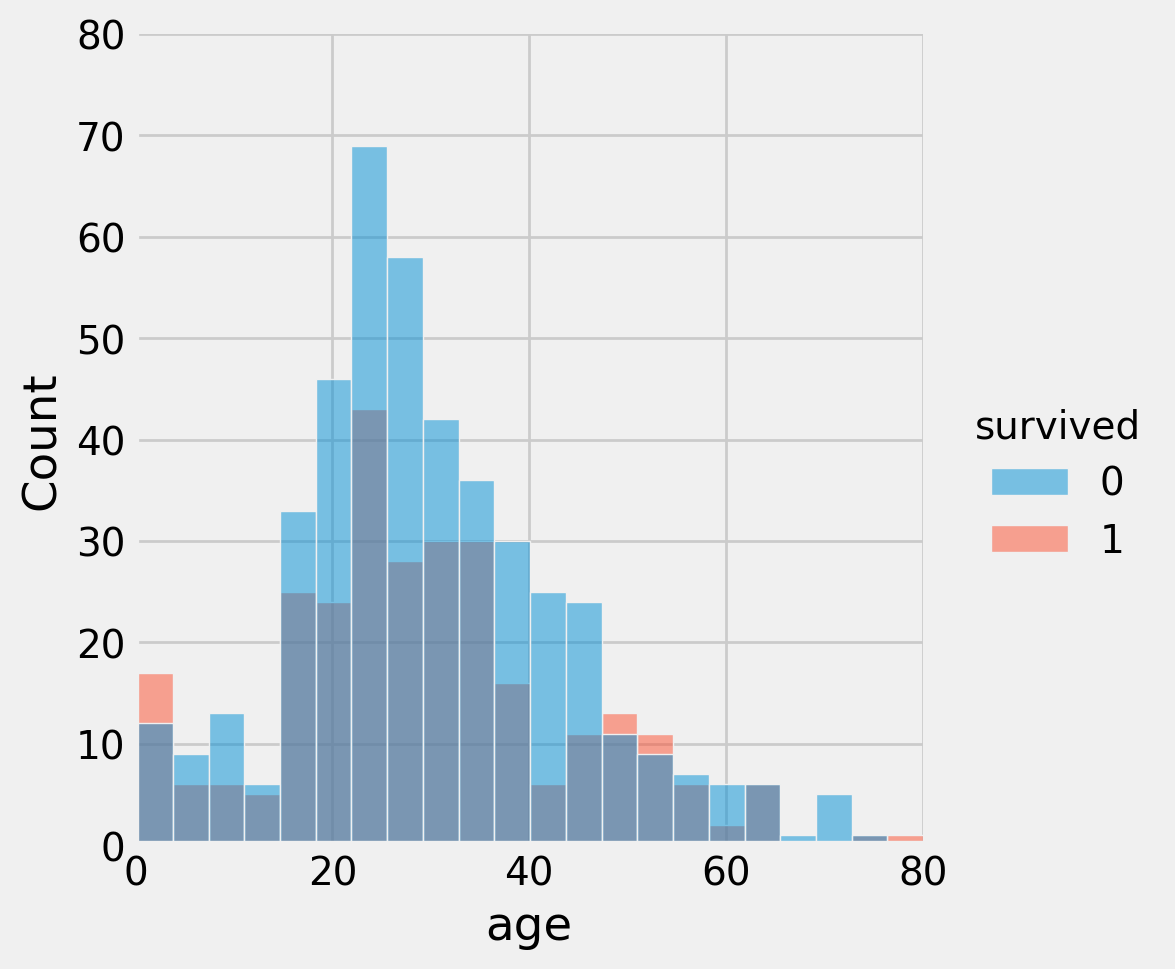

In [29]:
sns.displot(ori_train, x="age", hue="survived")
plt.xlim(0,80)
plt.ylim(0,80)

In [30]:
def alone(family):
  alone=3
  if family ==0:
    alone=1
  elif family ==1:
    alone=2
  else:
    pass
  return alone

train['alone']=train.apply(lambda x : alone(x['family']),axis=1)
test['alone']=test.apply(lambda x : alone(x['family']),axis=1)
ori_te['alone']=ori_te.apply(lambda x : alone(x['family']),axis=1)


In [31]:

def split_age(age):
    section= 4
    if age <10:
        section =1
    elif age < 20:
        section =2
    elif age >48:
        section =3
    else:
        pass
    return section

train['age_sec']= train.apply(lambda x : split_age(x['age']), axis =1 )
test['age_sec']= test.apply(lambda x : split_age(x['age']), axis =1 )
ori_te['age_sec']= ori_te.apply(lambda x : split_age(x['age']), axis =1 )

In [32]:
def fare_ran(fare):
    if fare <= 20 :
        ran=1
    elif fare < 80:
        ran =2
    else:
        ran =3
    return ran



train['fare_range']= train.apply(lambda x: fare_ran(x['fare']),axis=1)
test['fare_range']= test.apply(lambda x: fare_ran(x['fare']),axis=1)
ori_te['fare_range']= ori_te.apply(lambda x: fare_ran(x['fare']),axis=1)

In [33]:
# train['age_5']=train.apply(lambda x : x['age']//5, axis =1 )
# test['age_5']=test.apply(lambda x : x['age']//5, axis =1 )
# ori_te['age_5']=ori_te.apply(lambda x : x['age']//5, axis =1 )



In [34]:
train['fare_range'].value_counts()

fare_range
1    328
2    197
3     52
Name: count, dtype: int64

In [35]:
# train.drop(['fare'],axis=1, inplace=True)
# test.drop(['fare'],axis=1, inplace=True)
# ori_te.drop(['fare'],axis=1, inplace=True)

# train.drop(['age'],axis=1, inplace=True)
# test.drop(['age'],axis=1, inplace=True)
# ori_te.drop(['age'],axis=1, inplace=True)

train.drop(['parch'],axis=1, inplace=True)
test.drop(['parch'],axis=1, inplace=True)
ori_te.drop(['parch'],axis=1, inplace=True)

train.drop(['sibsp'],axis=1, inplace=True)
test.drop(['sibsp'],axis=1, inplace=True)
ori_te.drop(['sibsp'],axis=1, inplace=True)

train.drop(['embarked'],axis=1, inplace=True)
test.drop(['embarked'],axis=1, inplace=True)
ori_te.drop(['embarked'],axis=1, inplace=True)

data encoding

In [36]:
#onehotencoding은 문자열을 0과 1로 바꾸는 것이다.
from sklearn.preprocessing import OneHotEncoder
import category_encoders as ce

In [37]:
train.columns

Index(['pclass', 'gender', 'age', 'fare', 'designation', 'pclass_gender',
       'family', 'age_sec', 'gender_infant', 'alone', 'fare_range'],
      dtype='object')

In [38]:
#숫자형과 문자형을 분리한듯, 인코딩할 컬럼과 일반 컬럼을 나눔
normal_cols = [ 'family','age','fare']
enc_cols = list(set(train.columns) - set(normal_cols))
enc_cols

['age_sec',
 'alone',
 'fare_range',
 'gender_infant',
 'pclass',
 'gender',
 'pclass_gender',
 'designation']

In [39]:
no_category_cols = ['family','age','fare']
category_cols = list(set(train.columns) - set(no_category_cols))

train_no_category = train[no_category_cols]
train_category = train[category_cols]

test_no_category = test[no_category_cols]
test_category = test[category_cols]

ori_te_no_category = ori_te[no_category_cols]
ori_te_category = ori_te[category_cols]

In [40]:
category_cols

['age_sec',
 'alone',
 'fare_range',
 'gender_infant',
 'pclass',
 'gender',
 'pclass_gender',
 'designation']

In [41]:
train_category['gender'] = train_category['gender'].map({'male':1, 'female':2}).astype('category')
#train_category['embarked'] = train_category['embarked'].map({'S':1, 'C':2, 'Q':3}).astype('category')
train_category['designation'] = train_category['designation'].map({'Mr.':1, 'Miss.':2, 'Mrs.':3}).astype('category')
train_category['pclass_gender'] = train_category['pclass_gender'].astype('category')
train_category['gender_infant'] = train_category['gender_infant'].map({'male_0':1, 'female_0':2, 'male_1':3, 'female_1':4}).astype('category')
train_category['age_sec'] = train_category['age_sec'].astype('category')
train_category['pclass'] = train_category['pclass'].astype('category')
train_category['fare_range'] = train_category['fare_range'].astype('category')
train_category['alone'] = train_category['alone'].astype('category')

ori_te_category['gender'] = ori_te_category['gender'].map({'male':1, 'female':2}).astype('category')
#ori_te_category['embarked'] = ori_te_category['embarked'].map({'S':1, 'C':2, 'Q':3}).astype('category')
ori_te_category['designation'] = ori_te_category['designation'].map({'Mr.':1, 'Miss.':2, 'Mrs.':3}).astype('category')
ori_te_category['pclass_gender'] = ori_te_category['pclass_gender'].astype('category')
ori_te_category['gender_infant'] = ori_te_category['gender_infant'].map({'male_0':1, 'female_0':2, 'male_1':3, 'female_1':4}).astype('category')
ori_te_category['age_sec'] = ori_te_category['age_sec'].astype('category')
ori_te_category['pclass'] = ori_te_category['pclass'].astype('category')
ori_te_category['fare_range'] = ori_te_category['fare_range'].astype('category')
ori_te_category['alone'] = ori_te_category['alone'].astype('category')

test_category['gender'] = test_category['gender'].map({'male':1, 'female':2}).astype('category')
#test_category['embarked'] = test_category['embarked'].map({'S':1, 'C':2, 'Q':3}).astype('category')
test_category['designation'] = test_category['designation'].map({'Mr.':1, 'Miss.':2, 'Mrs.':3}).astype('category')
test_category['pclass_gender'] = test_category['pclass_gender'].astype('category')
test_category['gender_infant'] = test_category['gender_infant'].map({'male_0':1, 'female_0':2, 'male_1':3, 'female_1':4}).astype('category')
test_category['age_sec'] = test_category['age_sec'].astype('category')
test_category['pclass'] = test_category['pclass'].astype('category')
test_category['fare_range'] = test_category['fare_range'].astype('category')
test_category['alone'] = test_category['alone'].astype('category')


In [42]:
import category_encoders as ce

_train_encoded = pd.DataFrame()
_test_encoded = pd.DataFrame()
_ori_te_encoded = pd.DataFrame()

for col in category_cols:
  _encoder = ce.OneHotEncoder(use_cat_names=True)
  _encoder.fit(train_category[col])
  _encoded = _encoder.transform(train_category[col])
  _train_encoded = pd.concat([_train_encoded, _encoded], axis=1)

  _encoded = _encoder.transform(test_category[col])
  _test_encoded = pd.concat([_test_encoded, _encoded], axis=1)

  _encoded = _encoder.transform(ori_te_category[col])
  _ori_te_encoded = pd.concat([_ori_te_encoded, _encoded], axis=1)

In [43]:
enc_tr = pd.concat([train_no_category, _train_encoded], axis=1)
enc_tr.shape

enc_te = pd.concat([test_no_category, _test_encoded], axis=1)
enc_te.shape

enc_ori_te = pd.concat([ori_te_no_category, _ori_te_encoded], axis=1)
enc_ori_te.shape


(393, 31)

In [44]:
enc_tr

,family,age,fare,age_sec_4.0,age_sec_2.0,age_sec_1.0,age_sec_3.0,alone_1.0,alone_3.0,alone_2.0,...,gender_2.0,pclass_gender_2_m,pclass_gender_3_m,pclass_gender_1_m,pclass_gender_1_fe,pclass_gender_3_fe,pclass_gender_2_fe,designation_1.0,designation_2.0,designation_3.0
902,0,20.0,13.8625,1,0,0,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0
896,4,16.0,34.3750,0,1,0,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0
461,0,28.5,27.7208,1,0,0,0,1,0,0,...,0,0,0,1,0,0,0,1,0,0
507,0,18.0,73.5000,0,1,0,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0
119,0,32.0,56.4958,1,0,0,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
538,0,24.0,9.3250,1,0,0,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0
446,0,18.5,7.2833,0,1,0,0,1,0,0,...,1,0,0,0,0,1,0,0,1,0
879,2,10.0,24.1500,0,1,0,0,0,1,0,...,1,0,0,0,0,1,0,0,1,0
101,0,30.0,31.0000,1,0,0,0,1,0,0,...,1,0,0,0,1,0,0,0,1,0


## Scaling

In [45]:
enc_tr

,family,age,fare,age_sec_4.0,age_sec_2.0,age_sec_1.0,age_sec_3.0,alone_1.0,alone_3.0,alone_2.0,...,gender_2.0,pclass_gender_2_m,pclass_gender_3_m,pclass_gender_1_m,pclass_gender_1_fe,pclass_gender_3_fe,pclass_gender_2_fe,designation_1.0,designation_2.0,designation_3.0
902,0,20.0,13.8625,1,0,0,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0
896,4,16.0,34.3750,0,1,0,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0
461,0,28.5,27.7208,1,0,0,0,1,0,0,...,0,0,0,1,0,0,0,1,0,0
507,0,18.0,73.5000,0,1,0,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0
119,0,32.0,56.4958,1,0,0,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
538,0,24.0,9.3250,1,0,0,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0
446,0,18.5,7.2833,0,1,0,0,1,0,0,...,1,0,0,0,0,1,0,0,1,0
879,2,10.0,24.1500,0,1,0,0,0,1,0,...,1,0,0,0,0,1,0,0,1,0
101,0,30.0,31.0000,1,0,0,0,1,0,0,...,1,0,0,0,1,0,0,0,1,0


In [46]:
enc_te.isnull().sum().sum()

0

In [47]:
scaling_cols = no_category_cols
not_scaling_cols = list(set(enc_tr.columns) - set(scaling_cols))

from sklearn.preprocessing import RobustScaler

rbs = RobustScaler()
_scaled_tr = rbs.fit_transform(enc_tr[scaling_cols])
_scaled_te = rbs.transform(enc_te[scaling_cols])
_scaled_ori_te = rbs.transform(enc_ori_te[scaling_cols])

print(f'before: {enc_tr.shape} / {enc_te.shape}')
# train
tmp_tr = pd.DataFrame(
    _scaled_tr, 
    columns = scaling_cols
)
scaled_tr = pd.concat(
    [enc_tr[not_scaling_cols].reset_index(drop=True), tmp_tr.reset_index(drop=True)]
    , axis=1
).reset_index(drop=True)
# test
tmp_te = pd.DataFrame(
    _scaled_te, 
    columns = scaling_cols
)
scaled_te = pd.concat(
    [enc_te[not_scaling_cols].reset_index(drop=True), tmp_te.reset_index(drop=True)]
    , axis=1
).reset_index(drop=True)
# ori_test
tmp_te = pd.DataFrame(
    _scaled_ori_te, 
    columns = scaling_cols
)
scaled_ori_te = pd.concat(
    [enc_ori_te[not_scaling_cols].reset_index(drop=True), tmp_te.reset_index(drop=True)]
    , axis=1
).reset_index(drop=True)

print(f'after: {scaled_tr.shape} / {scaled_te.shape}')

before: (577, 31) / (339, 31)
after: (577, 31) / (339, 31)


In [48]:
y_tr

902    0
896    0
461    0
507    0
119    1
      ..
538    0
446    1
879    0
101    1
636    0
Name: survived, Length: 577, dtype: int64

In [49]:
enc_tr

,family,age,fare,age_sec_4.0,age_sec_2.0,age_sec_1.0,age_sec_3.0,alone_1.0,alone_3.0,alone_2.0,...,gender_2.0,pclass_gender_2_m,pclass_gender_3_m,pclass_gender_1_m,pclass_gender_1_fe,pclass_gender_3_fe,pclass_gender_2_fe,designation_1.0,designation_2.0,designation_3.0
902,0,20.0,13.8625,1,0,0,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0
896,4,16.0,34.3750,0,1,0,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0
461,0,28.5,27.7208,1,0,0,0,1,0,0,...,0,0,0,1,0,0,0,1,0,0
507,0,18.0,73.5000,0,1,0,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0
119,0,32.0,56.4958,1,0,0,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
538,0,24.0,9.3250,1,0,0,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0
446,0,18.5,7.2833,0,1,0,0,1,0,0,...,1,0,0,0,0,1,0,0,1,0
879,2,10.0,24.1500,0,1,0,0,0,1,0,...,1,0,0,0,0,1,0,0,1,0
101,0,30.0,31.0000,1,0,0,0,1,0,0,...,1,0,0,0,1,0,0,0,1,0


In [50]:
scaled_tr

,age_sec_3.0,designation_1.0,pclass_gender_2_fe,gender_infant_4.0,pclass_gender_2_m,gender_infant_1.0,alone_2.0,pclass_1.0,designation_2.0,fare_range_1.0,...,gender_1.0,designation_3.0,alone_3.0,pclass_gender_3_m,gender_infant_2.0,alone_1.0,fare_range_2.0,family,age,fare
0,0,1,0,0,1,1,0,0,0,1,...,1,0,0,0,0,1,0,0.0,-0.470588,-0.028879
1,0,1,0,0,0,1,0,0,0,0,...,1,0,1,1,0,0,1,4.0,-0.705882,0.900340
2,0,1,0,0,0,1,0,1,0,0,...,1,0,0,0,0,1,1,0.0,0.029412,0.598904
3,0,1,0,0,1,1,0,0,0,0,...,1,0,0,0,0,1,1,0.0,-0.588235,2.672707
4,0,1,0,0,0,1,0,0,0,0,...,1,0,0,1,0,1,1,0.0,0.235294,1.902414
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
572,0,1,0,0,0,1,0,0,0,1,...,1,0,0,1,0,1,0,0.0,-0.235294,-0.234428
573,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,1,1,0,0.0,-0.558824,-0.326917
574,0,0,0,0,0,0,0,0,1,0,...,0,0,1,0,1,0,1,2.0,-1.058824,0.437146
575,0,0,0,0,0,0,0,1,1,0,...,0,0,0,0,1,1,1,0.0,0.117647,0.747452


In [51]:
enc_tr.isnull().sum().sum(), enc_te.isnull().sum().sum(), enc_ori_te.isnull().sum().sum()

(0, 0, 0)

In [52]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, plot_importance
from lightgbm import LGBMClassifier, plot_importance
from catboost import CatBoostClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score


In [53]:
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

## Training

In [54]:
X= pd.concat([scaled_tr,y_tr.reset_index(drop=True)],axis=1)

In [55]:
y= pd.concat([scaled_te,y_te.reset_index(drop=True)],axis=1)

In [56]:
scaled_tr.shape, y_tr.shape

((577, 31), (577,))

In [57]:
X.shape, y.shape

((577, 32), (339, 32))

In [58]:
X=pd.concat([X,y],axis=0)

In [59]:
X.shape

(916, 32)

In [60]:
y=X['survived']
y = ori_train['survived']
X = X.drop(['survived'], axis=1)

In [61]:
X.shape, y.shape

((916, 31), (916,))

In [62]:
hp3 = {
    'n_estimators': 1200,
    'max_depth': 3,
    'learning_rate' : 0.01,
    'verbose': 0,
    'random_state': 42
    
}

In [64]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# 데이터를 로드하고 전처리 (X, y를 설정)

# 모델 정의
model = CatBoostClassifier(**hp3)

# 테스트 크기 범위 설정
test_size_range = np.arange(0.1, 0.46, 0.02)  # 원하는 범위로 설정

# 결과를 저장할 리스트 초기화
mean_scores = []

# 각 테스트 크기에 대한 교차 검증 수행
for test_size in test_size_range:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=3,scoring='roc_auc')  # 5-fold 교차 검증
    mean_score = np.mean(scores)
    mean_scores.append(mean_score)

# 최적의 테스트 크기 선택
optimal_test_size = test_size_range[np.argmax(mean_scores)]
print(f"최적의 테스트 세트 크기: {optimal_test_size:.2f}")



최적의 테스트 세트 크기: 0.40


In [ ]:
scor = 'roc_auc'
kn=8

In [ ]:
hp1 = {
    'n_estimators': 2000,
    'max_depth': 9,
    'random_state' : 42
}



In [ ]:
# tree_model = RandomForestClassifier(**hp1)
# tree_model.fit(scaled_tr, y_tr)

In [ ]:
n_iter = 0
auc_lst = []
kf = KFold(n_splits=kn, shuffle=True, random_state=42)

tree_model = RandomForestClassifier(**hp1)

for train_index, valid_index in kf.split(scaled_tr):
    n_iter += 1
    # 학습용, 검증용 데이터 구성
    train_x, valid_x = scaled_tr.iloc[train_index], scaled_tr.iloc[valid_index]
    train_y, valid_y = y_tr.iloc[train_index], y_tr.iloc[valid_index]
    # 학습
    tree_model.fit(train_x, train_y)
    # 예측
    pred = tree_model.predict_proba(valid_x)[:,1]
    # 평가
    
    fpr, tpr, thresholds = roc_curve(valid_y,pred)
    auc_te = auc(fpr, tpr)
    auc_lst.append(auc_te)
    print(f'{n_iter} 번째 K-fold auc: {auc_te}, 학습데이터 크기: {train_x.shape}, 검증데이터 크기: {valid_x.shape}')

# 최종 평가
print('-'*50)
print(f'교차 검증 정확도: {np.mean(auc_lst)} / 모델 평가: {tree_model.score(scaled_te, y_te)}')

1 번째 K-fold auc: 0.9075, 학습데이터 크기: (504, 31), 검증데이터 크기: (73, 31)
2 번째 K-fold auc: 0.865531914893617, 학습데이터 크기: (505, 31), 검증데이터 크기: (72, 31)
3 번째 K-fold auc: 0.8371361132966166, 학습데이터 크기: (505, 31), 검증데이터 크기: (72, 31)
4 번째 K-fold auc: 0.9254545454545455, 학습데이터 크기: (505, 31), 검증데이터 크기: (72, 31)
5 번째 K-fold auc: 0.8762541806020068, 학습데이터 크기: (505, 31), 검증데이터 크기: (72, 31)
6 번째 K-fold auc: 0.8939628482972136, 학습데이터 크기: (505, 31), 검증데이터 크기: (72, 31)
7 번째 K-fold auc: 0.8519841269841271, 학습데이터 크기: (505, 31), 검증데이터 크기: (72, 31)
8 번째 K-fold auc: 0.8970212765957446, 학습데이터 크기: (505, 31), 검증데이터 크기: (72, 31)
--------------------------------------------------
교차 검증 정확도: 0.8818556257654839 / 모델 평가: 0.8672566371681416


In [ ]:
best_model = tree_model

In [ ]:
#7, 1500으로 두자 그냥

In [ ]:
hp2 = {
    'n_estimators': 1200,
    'max_depth': 3,
    'learning_rate' : 0.01,
    'verbose': 0,
    'random_state': 42
    
}



In [ ]:
# lgb = LGBMClassifier(**hp2)
# lgb.fit(scaled_tr, y_tr)


In [ ]:
n_iter = 0
auc_lst = []
kf = KFold(n_splits=kn, shuffle=True, random_state=42)

lgb = LGBMClassifier(**hp2)
for train_index, valid_index in kf.split(scaled_tr):
    n_iter += 1
    # 학습용, 검증용 데이터 구성
    train_x, valid_x = scaled_tr.iloc[train_index], scaled_tr.iloc[valid_index]
    train_y, valid_y = y_tr.iloc[train_index], y_tr.iloc[valid_index]
    # 학습
    lgb.fit(train_x, train_y)
    # 예측
    pred = lgb.predict_proba(valid_x)[:,1]
    # 평가
    
    fpr, tpr, thresholds = roc_curve(valid_y,pred)
    auc_te = auc(fpr, tpr)
    auc_lst.append(auc_te)
    print(f'{n_iter} 번째 K-fold auc: {auc_te}, 학습데이터 크기: {train_x.shape}, 검증데이터 크기: {valid_x.shape}')

# 최종 평가
print('-'*50)
print(f'교차 검증 정확도: {np.mean(auc_lst)} / 모델 평가: {lgb.score(scaled_te, y_te)}')

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [ ]:
best_model2 = lgb

In [ ]:
hp3 = {
    'n_estimators': 1200,
    'max_depth': 3,
    'learning_rate' : 0.01,
    'verbose': 0,
    'learning_rate': 0.01,
    'random_state': 42
    
}


In [ ]:
# cat_mo = CatBoostClassifier(**hp3)
# cat_mo.fit(scaled_tr, y_tr)

In [ ]:
# n_iter = 0
# auc_lst = []
# kf = KFold(n_splits=kn, shuffle=True, random_state=42)

# cat_mo = CatBoostClassifier(**hp3)
# for train_index, valid_index in kf.split(scaled_tr):
#     n_iter += 1
#     # 학습용, 검증용 데이터 구성
#     train_x, valid_x = scaled_tr.iloc[train_index], scaled_tr.iloc[valid_index]
#     train_y, valid_y = y_tr.iloc[train_index], y_tr.iloc[valid_index]
#     # 학습
#     cat_mo.fit(train_x, train_y)
#     # 예측
#     pred = cat_mo.predict_proba(valid_x)[:,1]
#     # 평가
    
#     fpr, tpr, thresholds = roc_curve(valid_y,pred)
#     auc_te = auc(fpr, tpr)
#     auc_lst.append(auc_te)
#     print(f'{n_iter} 번째 K-fold auc: {auc_te}, 학습데이터 크기: {train_x.shape}, 검증데이터 크기: {valid_x.shape}')

# # 최종 평가
# print('-'*50)
# print(f'교차 검증 정확도: {np.mean(auc_lst)} / 모델 평가: {cat_mo.score(scaled_te, y_te)}')

In [ ]:
# 모델 생성
cat_mo = CatBoostClassifier()

# 탐색할 하이퍼파라미터 그리드 정의
param_grid = {
    'n_estimators': [1200,1500],
    #'iterations ': [1000,2000],
    'max_depth': [3,5],
    'learning_rate' : [0.015,0.01],
    'random_state':[42],
    'verbose' : [0],
    'loss_function':['Logloss','CrossEntropy'],
}

# Grid Search + Cross Validation 모두 실행
grid_search = GridSearchCV(estimator=cat_mo, param_grid=param_grid, cv=3, scoring = scor,verbose =3)
grid_search.fit(scaled_tr, y_tr)

# 최적 하이퍼파라미터 및 모델 출력
best_params3 = grid_search.best_params_
best_model3 = grid_search.best_estimator_
best_score3 = grid_search.best_score_

print("Best Hyperparameters:", best_params3)
print("Best Model:", best_model3)
print("Best Model Score:", best_score3)


Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV 1/3] END learning_rate=0.015, loss_function=Logloss, max_depth=3, n_estimators=1200, random_state=42, verbose=0;, score=0.893 total time=   2.2s
[CV 2/3] END learning_rate=0.015, loss_function=Logloss, max_depth=3, n_estimators=1200, random_state=42, verbose=0;, score=0.879 total time=   2.3s
[CV 3/3] END learning_rate=0.015, loss_function=Logloss, max_depth=3, n_estimators=1200, random_state=42, verbose=0;, score=0.866 total time=   2.3s
[CV 1/3] END learning_rate=0.015, loss_function=Logloss, max_depth=3, n_estimators=1500, random_state=42, verbose=0;, score=0.890 total time=   2.8s
[CV 2/3] END learning_rate=0.015, loss_function=Logloss, max_depth=3, n_estimators=1500, random_state=42, verbose=0;, score=0.875 total time=   2.9s
[CV 3/3] END learning_rate=0.015, loss_function=Logloss, max_depth=3, n_estimators=1500, random_state=42, verbose=0;, score=0.868 total time=   3.5s
[CV 1/3] END learning_rate=0.015, loss_functi

In [ ]:
# best_model3 = cat_mo

In [ ]:
# # 모델 생성 estimor = 1200, 0.01
# light = LGBMClassifier()

# # 탐색할 하이퍼파라미터 그리드 정의
# param_grid = {
#     'n_estimators': [1200,1500],
#     'max_depth': [3],
#     'learning_rate' : [0.01],
#     'random_state' : [42],
#     'verbose': [0]
# }

# # Grid Search 수행
# grid_search = GridSearchCV(estimator=light, param_grid=param_grid, cv=4, scoring = scor,verbose =3)
# grid_search.fit(scaled_tr, y_tr)

# # 최적 하이퍼파라미터 및 모델 출력
# best_params2 = grid_search.best_params_
# best_model2 = grid_search.best_estimator_
# best_score2= grid_search.best_score_

# print("Best Hyperparameters:", best_params2)
# print("Best Model:", best_model2)
# print("Best Model Score:", best_score2)


In [ ]:
hp4 = {
    'n_estimators': 1200,
    'max_depth': 3,
    'learning_rate' : 0.01,
    'verbose': 0,
    'random_state': 42
    
}



In [ ]:
XGB_mo = XGBClassifier(**hp4)
XGB_mo.fit(scaled_tr, y_tr)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1200, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [ ]:
n_iter = 0
auc_lst = []
kf = KFold(n_splits=kn, shuffle=True, random_state=42)

XGB_mo = XGBClassifier(**hp4)
for train_index, valid_index in kf.split(scaled_tr):
    n_iter += 1
    # 학습용, 검증용 데이터 구성
    train_x, valid_x = scaled_tr.iloc[train_index], scaled_tr.iloc[valid_index]
    train_y, valid_y = y_tr.iloc[train_index], y_tr.iloc[valid_index]
    # 학습
    XGB_mo.fit(train_x, train_y)
    # 예측
    pred = XGB_mo.predict_proba(valid_x)[:,1]
    # 평가
    
    fpr, tpr, thresholds = roc_curve(valid_y,pred)
    auc_te = auc(fpr, tpr)
    auc_lst.append(auc_te)
    print(f'{n_iter} 번째 K-fold auc: {auc_te}, 학습데이터 크기: {train_x.shape}, 검증데이터 크기: {valid_x.shape}')

# 최종 평가
print('-'*50)
print(f'교차 검증 정확도: {np.mean(auc_lst)} / 모델 평가: {XGB_mo.score(scaled_te, y_te)}')

1 번째 K-fold auc: 0.9099999999999999, 학습데이터 크기: (504, 31), 검증데이터 크기: (73, 31)
2 번째 K-fold auc: 0.9191489361702128, 학습데이터 크기: (505, 31), 검증데이터 크기: (72, 31)
3 번째 K-fold auc: 0.8217938630999213, 학습데이터 크기: (505, 31), 검증데이터 크기: (72, 31)
4 번째 K-fold auc: 0.9522727272727273, 학습데이터 크기: (505, 31), 검증데이터 크기: (72, 31)
5 번째 K-fold auc: 0.8959030100334447, 학습데이터 크기: (505, 31), 검증데이터 크기: (72, 31)
6 번째 K-fold auc: 0.861455108359133, 학습데이터 크기: (505, 31), 검증데이터 크기: (72, 31)
7 번째 K-fold auc: 0.8873015873015874, 학습데이터 크기: (505, 31), 검증데이터 크기: (72, 31)
8 번째 K-fold auc: 0.8680851063829786, 학습데이터 크기: (505, 31), 검증데이터 크기: (72, 31)
--------------------------------------------------
교차 검증 정확도: 0.8894950423275007 / 모델 평가: 0.8731563421828908


In [ ]:
best_model4 = XGB_mo

In [ ]:
# # 모델 생성
# cat_mo = CatBoostClassifier()

# # 탐색할 하이퍼파라미터 그리드 정의
# param_grid = {
#     'n_estimators': [1200],
#     'max_depth': [3,4],
#     'learning_rate' : [0.01],
#     'random_state' : [42],
#     'verbose': [0]
# }

# # Grid Search 수행
# grid_search = GridSearchCV(estimator=cat_mo, param_grid=param_grid, cv=3, scoring = scor,verbose =3)
# grid_search.fit(scaled_tr, y_tr)

# # 최적 하이퍼파라미터 및 모델 출력
# best_params3 = grid_search.best_params_
# best_model3 = grid_search.best_estimator_
# best_score3 = grid_search.best_score_

# print("Best Hyperparameters:", best_params3)
# print("Best Model:", best_model3)
# print("Best Model Score:", best_score3)


In [ ]:
# # 모델 생성
# XGB_mo = XGBClassifier()

# # 탐색할 하이퍼파라미터 그리드 정의
# param_grid = {
#     'n_estimators': [1200, 1800,1500],
#     'max_depth': [3,4,5],
#     'learning_rate' : [0.01],
#     'random_state' : [42],
# }

# # Grid Search 수행
# grid_search = GridSearchCV(estimator=XGB_mo, param_grid=param_grid, cv=2, scoring = scor,verbose =3)
# grid_search.fit(scaled_tr, y_tr)

# # 최적 하이퍼파라미터 및 모델 출력
# best_params4 = grid_search.best_params_
# best_model4 = grid_search.best_estimator_
# best_score4 = grid_search.best_score_

# print("Best Hyperparameters:", best_params4)
# print("Best Model:", best_model4)
# print("Best Model Score:", best_score4)


In [ ]:
'''
estimer 2000일때 maxdepth는 9일때 제일 굿
Best Hyperparameters: {'max_depth': 5, 'n_estimators': 1400}
Best Model: <catboost.core.CatBoostClassifier object at 0x000002310F4E44D0>
Best Model Score: 0.8804668991518474

'''

"\nestimer 2000일때 maxdepth는 9일때 제일 굿\nBest Hyperparameters: {'max_depth': 5, 'n_estimators': 1400}\nBest Model: <catboost.core.CatBoostClassifier object at 0x000002310F4E44D0>\nBest Model Score: 0.8804668991518474\n\n"

## Evaluation

In [ ]:
rfc = best_model

In [ ]:
score_tr = rfc.score(scaled_tr, y_tr)
y_tr_pred= rfc.predict_proba(scaled_tr)[:,1]
score_te = rfc.score(scaled_te, y_te) 

score_tr, score_te  

(0.9272097053726169, 0.8613569321533924)

In [ ]:
fpr, tpr, thresholds = roc_curve(y_tr,y_tr_pred)

auc_tr = auc(fpr, tpr)
print(f'model: {auc_tr}')

model: 0.9741764841174516


In [ ]:
y_pred0 = rfc.predict_proba(scaled_te)[:,1]
fpr, tpr, thresholds = roc_curve(y_te,y_pred0)

auc_te = auc(fpr, tpr)
print(f'model: {auc_te}')

model: 0.9281324052132701


In [ ]:
ori_te_pred = rfc.predict_proba(scaled_ori_te)[:,1]
ori_te_pred.shape

(393,)

In [ ]:
df_feature_importances = pd.DataFrame(rfc.feature_importances_, scaled_tr.columns).sort_values(by=[0], ascending=False).reset_index()

print(f'{df_feature_importances.shape}')
df_feature_importances

(31, 2)


,index,0
0,designation_1.0,0.124634
1,gender_1.0,0.120963
2,gender_2.0,0.113609
3,fare,0.110777
4,age,0.110170
5,gender_infant_1.0,0.080616
6,gender_infant_2.0,0.069015
7,family,0.036840
8,designation_2.0,0.029297
9,pclass_gender_3_m,0.022612


In [ ]:
args.results.append(
    {
        'model': 'rfc',
        'score_tr': score_tr,
        'score_te': score_te,
        'auc_tr': auc_tr,
        'auc_te': auc_te,
        'len_features': scaled_tr.shape[1],
        'feaute_importances': list(df_feature_importances['index'].values[:X_tr.shape[1]]),
        'create_dt': '0217',
        'ori_te_pred': ori_te_pred
    }
)

# args.results

# light

In [ ]:
light=best_model2
score_tr = light.score(scaled_tr, y_tr)
y_tr_pred= light.predict_proba(scaled_tr)[:,1]
score_te = light.score(scaled_te, y_te) 

score_tr, score_te  


(0.8977469670710572, 0.8584070796460177)

In [ ]:
fpr, tpr, thresholds = roc_curve(y_tr,y_tr_pred)

auc_tr = auc(fpr, tpr)
print(f'model: {auc_tr}')

model: 0.9487171296414608


In [ ]:
y_pred2 = light.predict_proba(scaled_te)[:,1]
fpr, tpr, thresholds = roc_curve(y_te,y_pred2)

auc_te = auc(fpr, tpr)
print(f'model: {auc_te}')

model: 0.9237818424170616


In [ ]:

ori_te_pred = light.predict_proba(scaled_ori_te)[:,1]
ori_te_pred.shape
df_feature_importances = pd.DataFrame(light.feature_importances_, scaled_tr.columns).sort_values(by=[0], ascending=False).reset_index()

print(f'{df_feature_importances.shape}')
# plot_importance(cat)
# plt.show()
args.results.append(
    {
        'model': 'light',
        'score_tr': score_tr,
        'score_te': score_te,
        'auc_tr': auc_tr,
        'auc_te': auc_te,
        'len_features': scaled_tr.shape[1],
        'feaute_importances': list(df_feature_importances['index'].values[:X_tr.shape[1]]),
        'create_dt': '0217',
        'ori_te_pred': ori_te_pred
    }
)

# args.results

(31, 2)


# Cat

In [ ]:
cat=best_model3

In [ ]:
score_tr = cat.score(scaled_tr, y_tr)
y_tr_pred= cat.predict_proba(scaled_tr)[:,1]
score_te = cat.score(scaled_te, y_te) 

score_tr, score_te  

(0.8960138648180243, 0.8820058997050148)

In [ ]:
fpr, tpr, thresholds = roc_curve(y_tr,y_tr_pred)

auc_tr = auc(fpr, tpr)
print(f'model: {auc_tr}')

model: 0.9426158288824718


In [ ]:
from sklearn.metrics import roc_curve, auc 

y_pred3 = cat.predict_proba(scaled_te)[:,1]
fpr, tpr, thresholds = roc_curve(y_te,y_pred3)

auc_te = auc(fpr, tpr)
print(f'model: {auc_te}')

model: 0.9277436315165877


In [ ]:
ori_te_pred = cat.predict_proba(scaled_ori_te)[:,1]
ori_te_pred.shape

(393,)

In [ ]:
df_feature_importances = pd.DataFrame(cat.feature_importances_, scaled_tr.columns).sort_values(by=[0], ascending=False).reset_index()

print(f'{df_feature_importances.shape}')
# plot_importance(cat)
# plt.show()

(31, 2)


In [ ]:
args.results.append(
    {
        'model': 'cat',
        'score_tr': score_tr,
        'score_te': score_te,
        'auc_tr': auc_tr,
        'auc_te': auc_te,
        
        'len_features': scaled_tr.shape[1],
        'feaute_importances': list(df_feature_importances['index'].values[:X_tr.shape[1]]),
        'create_dt': '0217',
        'ori_te_pred': ori_te_pred
    }
)

# args.results

# XGB

In [ ]:
xgb=best_model4

In [ ]:
score_tr = xgb.score(scaled_tr, y_tr)
y_tr_pred= xgb.predict_proba(scaled_tr)[:,1]
score_te = xgb.score(scaled_te, y_te) 

score_tr, score_te  

(0.8977469670710572, 0.8731563421828908)

In [ ]:
fpr, tpr, thresholds = roc_curve(y_tr,y_tr_pred)

auc_tr = auc(fpr, tpr)
print(f'model: {auc_tr}')

model: 0.9494901740308196


In [ ]:
from sklearn.metrics import roc_curve, auc 

y_pred4 = xgb.predict_proba(scaled_te)[:,1]
fpr, tpr, thresholds = roc_curve(y_te,y_pred4)

auc_te = auc(fpr, tpr)
print(f'model: {auc_te}')

model: 0.9283360485781991


In [ ]:
ori_te_pred = xgb.predict_proba(scaled_ori_te)[:,1]
ori_te_pred.shape

(393,)

In [ ]:
df_feature_importances = pd.DataFrame(xgb.feature_importances_, scaled_tr.columns).sort_values(by=[0], ascending=False).reset_index()

print(f'{df_feature_importances.shape}')



(31, 2)


In [ ]:
args.results.append(
    {
        'model': 'XGB_',
        'score_tr': score_tr,
        'score_te': score_te,
        'auc_tr': auc_tr,
        'auc_te': auc_te,
        'len_features': scaled_tr.shape[1],
        'feaute_importances': list(df_feature_importances['index'].values[:X_tr.shape[1]]),
        'create_dt': '0217',
        'ori_te_pred': ori_te_pred
    }
)

# args.results

# Submission

In [ ]:
df_results = pd.DataFrame(args.results).sort_values(by=['auc_te'], ascending=False)
df_results

,model,score_tr,score_te,auc_tr,auc_te,len_features,feaute_importances,create_dt,ori_te_pred
3,XGB_,0.897747,0.873156,0.949490,0.928336,31,"[gender_1.0, gender_infant_1.0, pclass_gender_...",0217,"[0.8620385, 0.88847274, 0.8444157, 0.08374659,..."
0,rfc,0.927210,0.861357,0.974176,0.928132,31,"[designation_1.0, gender_1.0, gender_2.0, fare...",0217,"[0.7648912773825741, 0.9644213810423349, 0.766..."
2,cat,0.896014,0.882006,0.942616,0.927744,31,"[fare, designation_1.0, gender_2.0, gender_inf...",0217,"[0.8001436825745893, 0.8955666296090747, 0.826..."
1,light,0.897747,0.858407,0.948717,0.923782,31,"[fare, age, gender_1.0, family, alone_1.0, pcl...",0217,"[0.8711989278360175, 0.9197604022459092, 0.846..."


In [ ]:
# plot_importance(modelV0)
# plt.show()

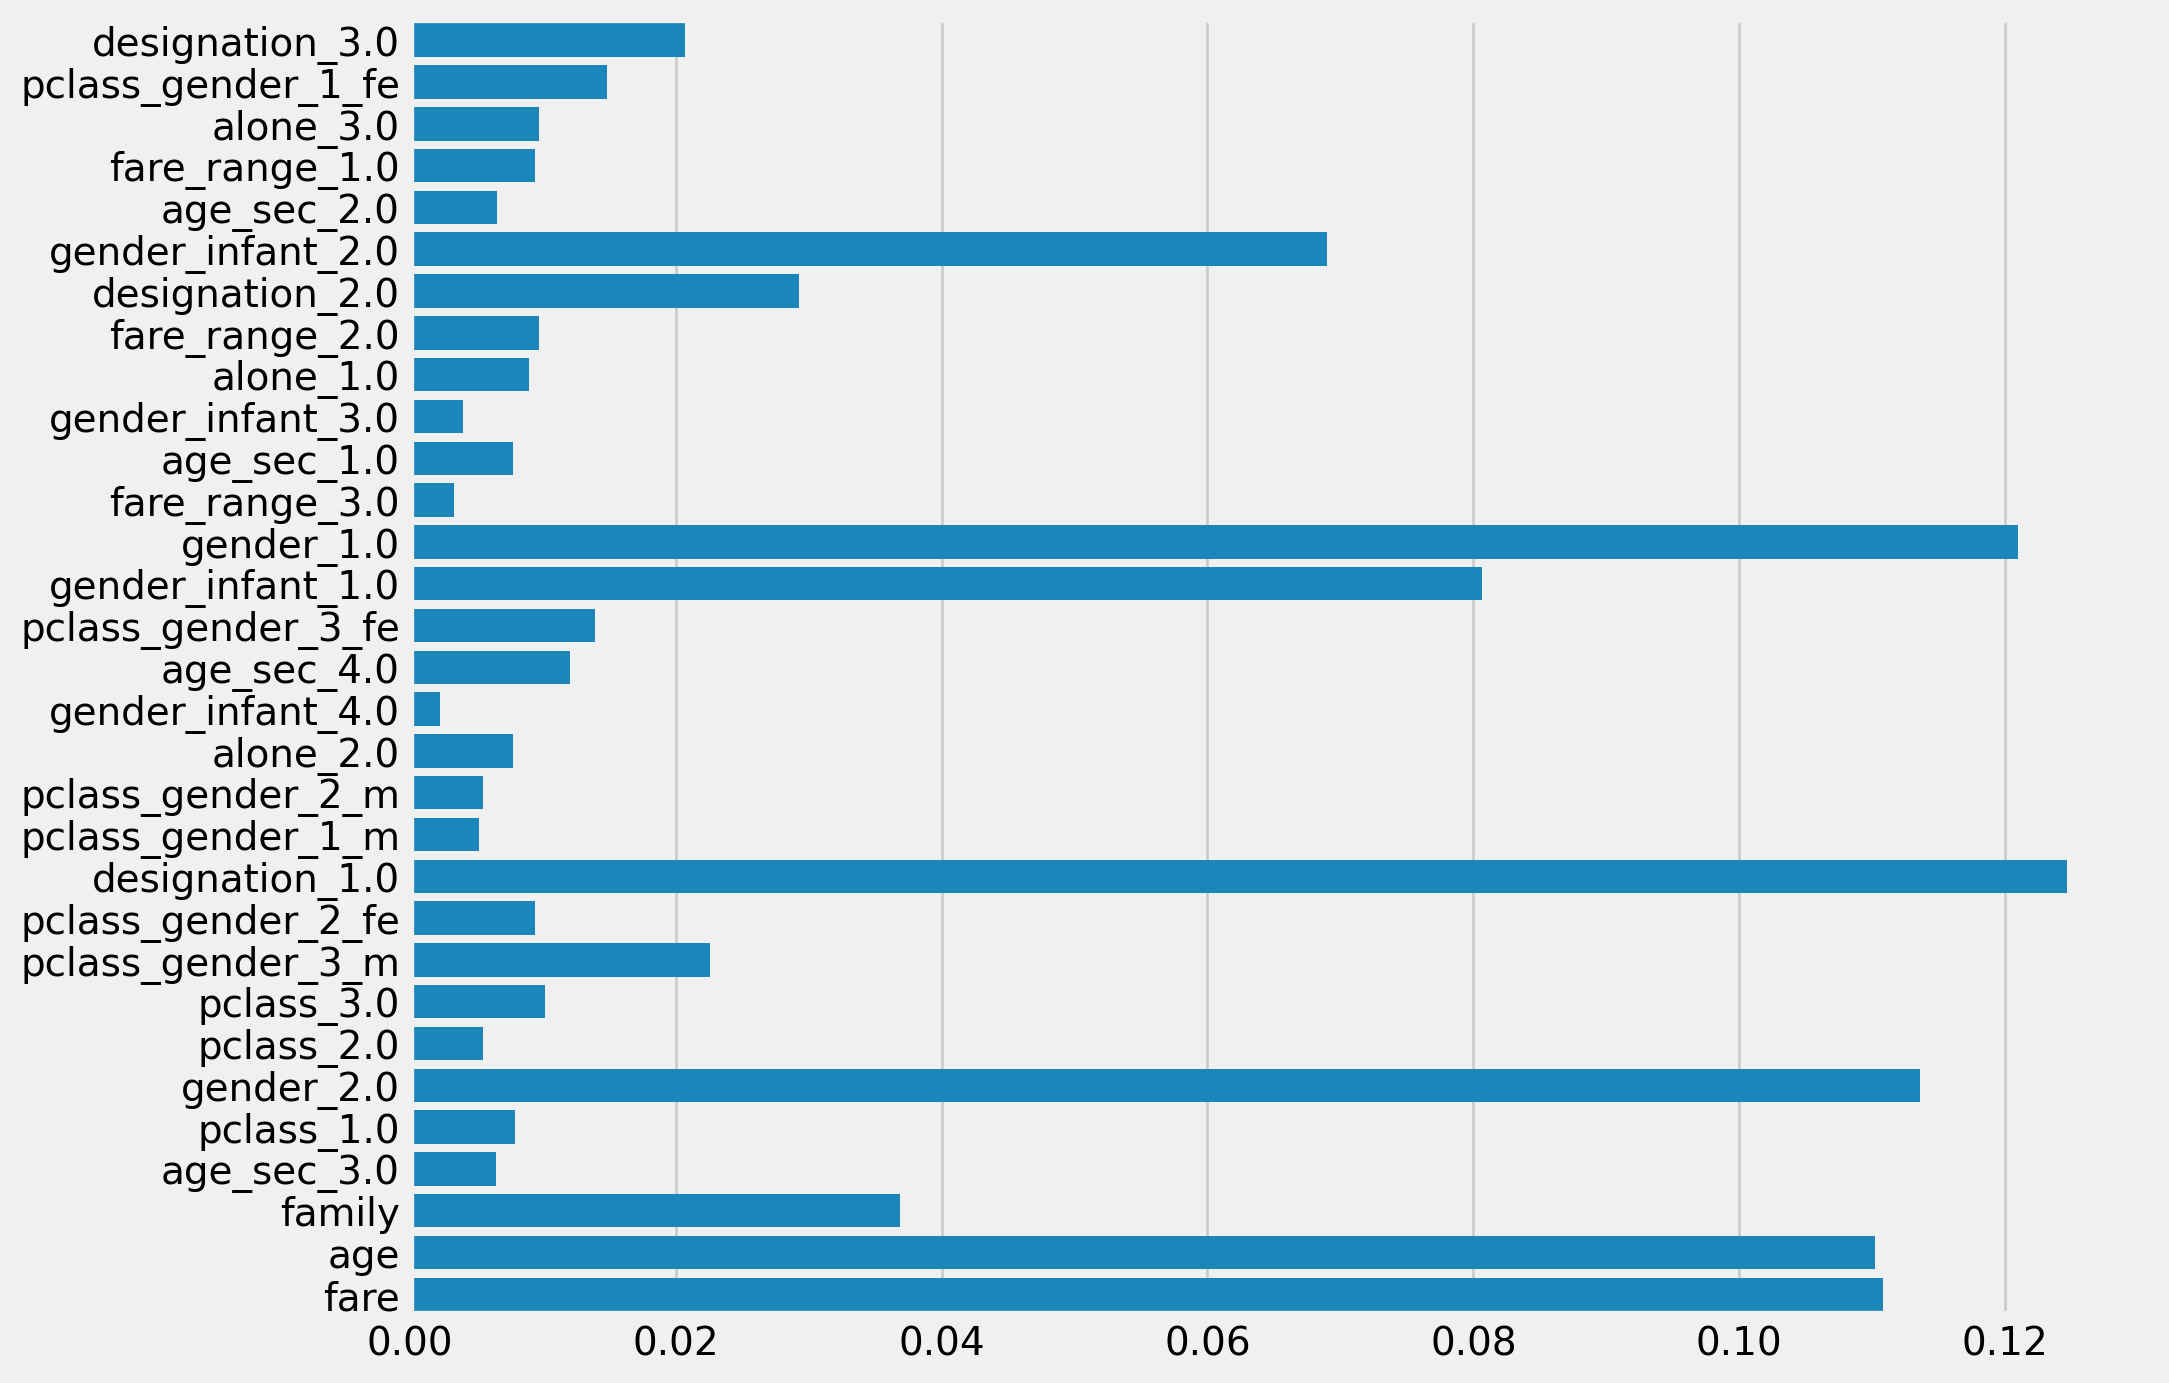

In [ ]:
plt.figure(figsize=(10,8))

sns.barplot(x=rfc.feature_importances_,y=scaled_tr.columns.to_numpy())
plt.show()

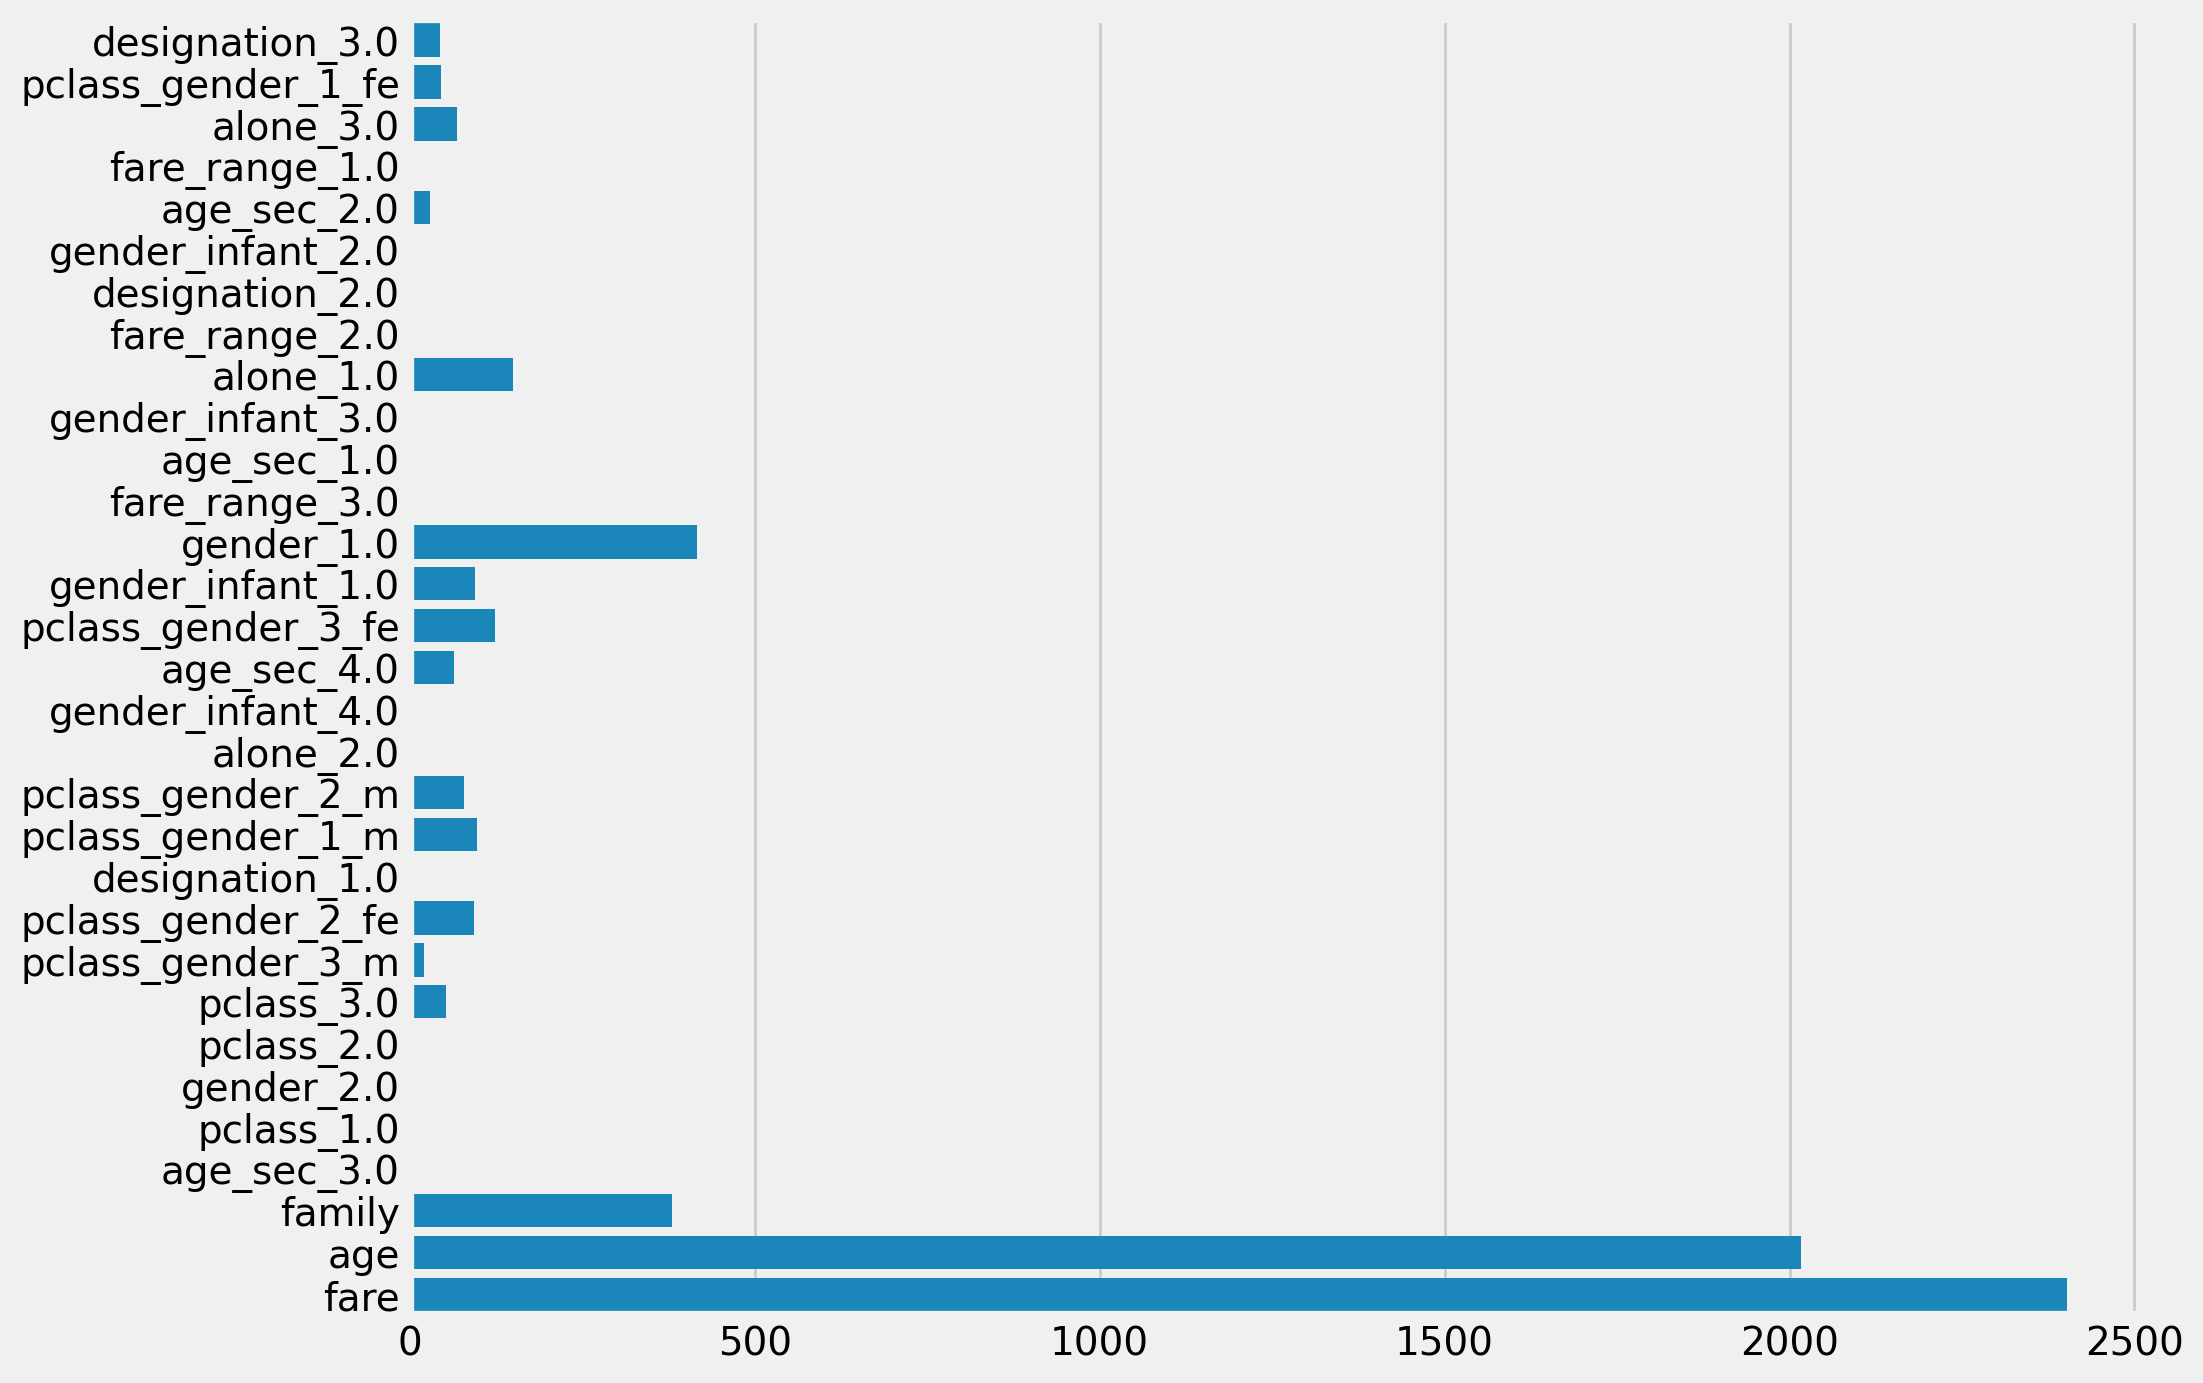

In [ ]:
plt.figure(figsize=(10,8))

sns.barplot(x=light.feature_importances_,y=scaled_tr.columns.to_numpy())
plt.show()

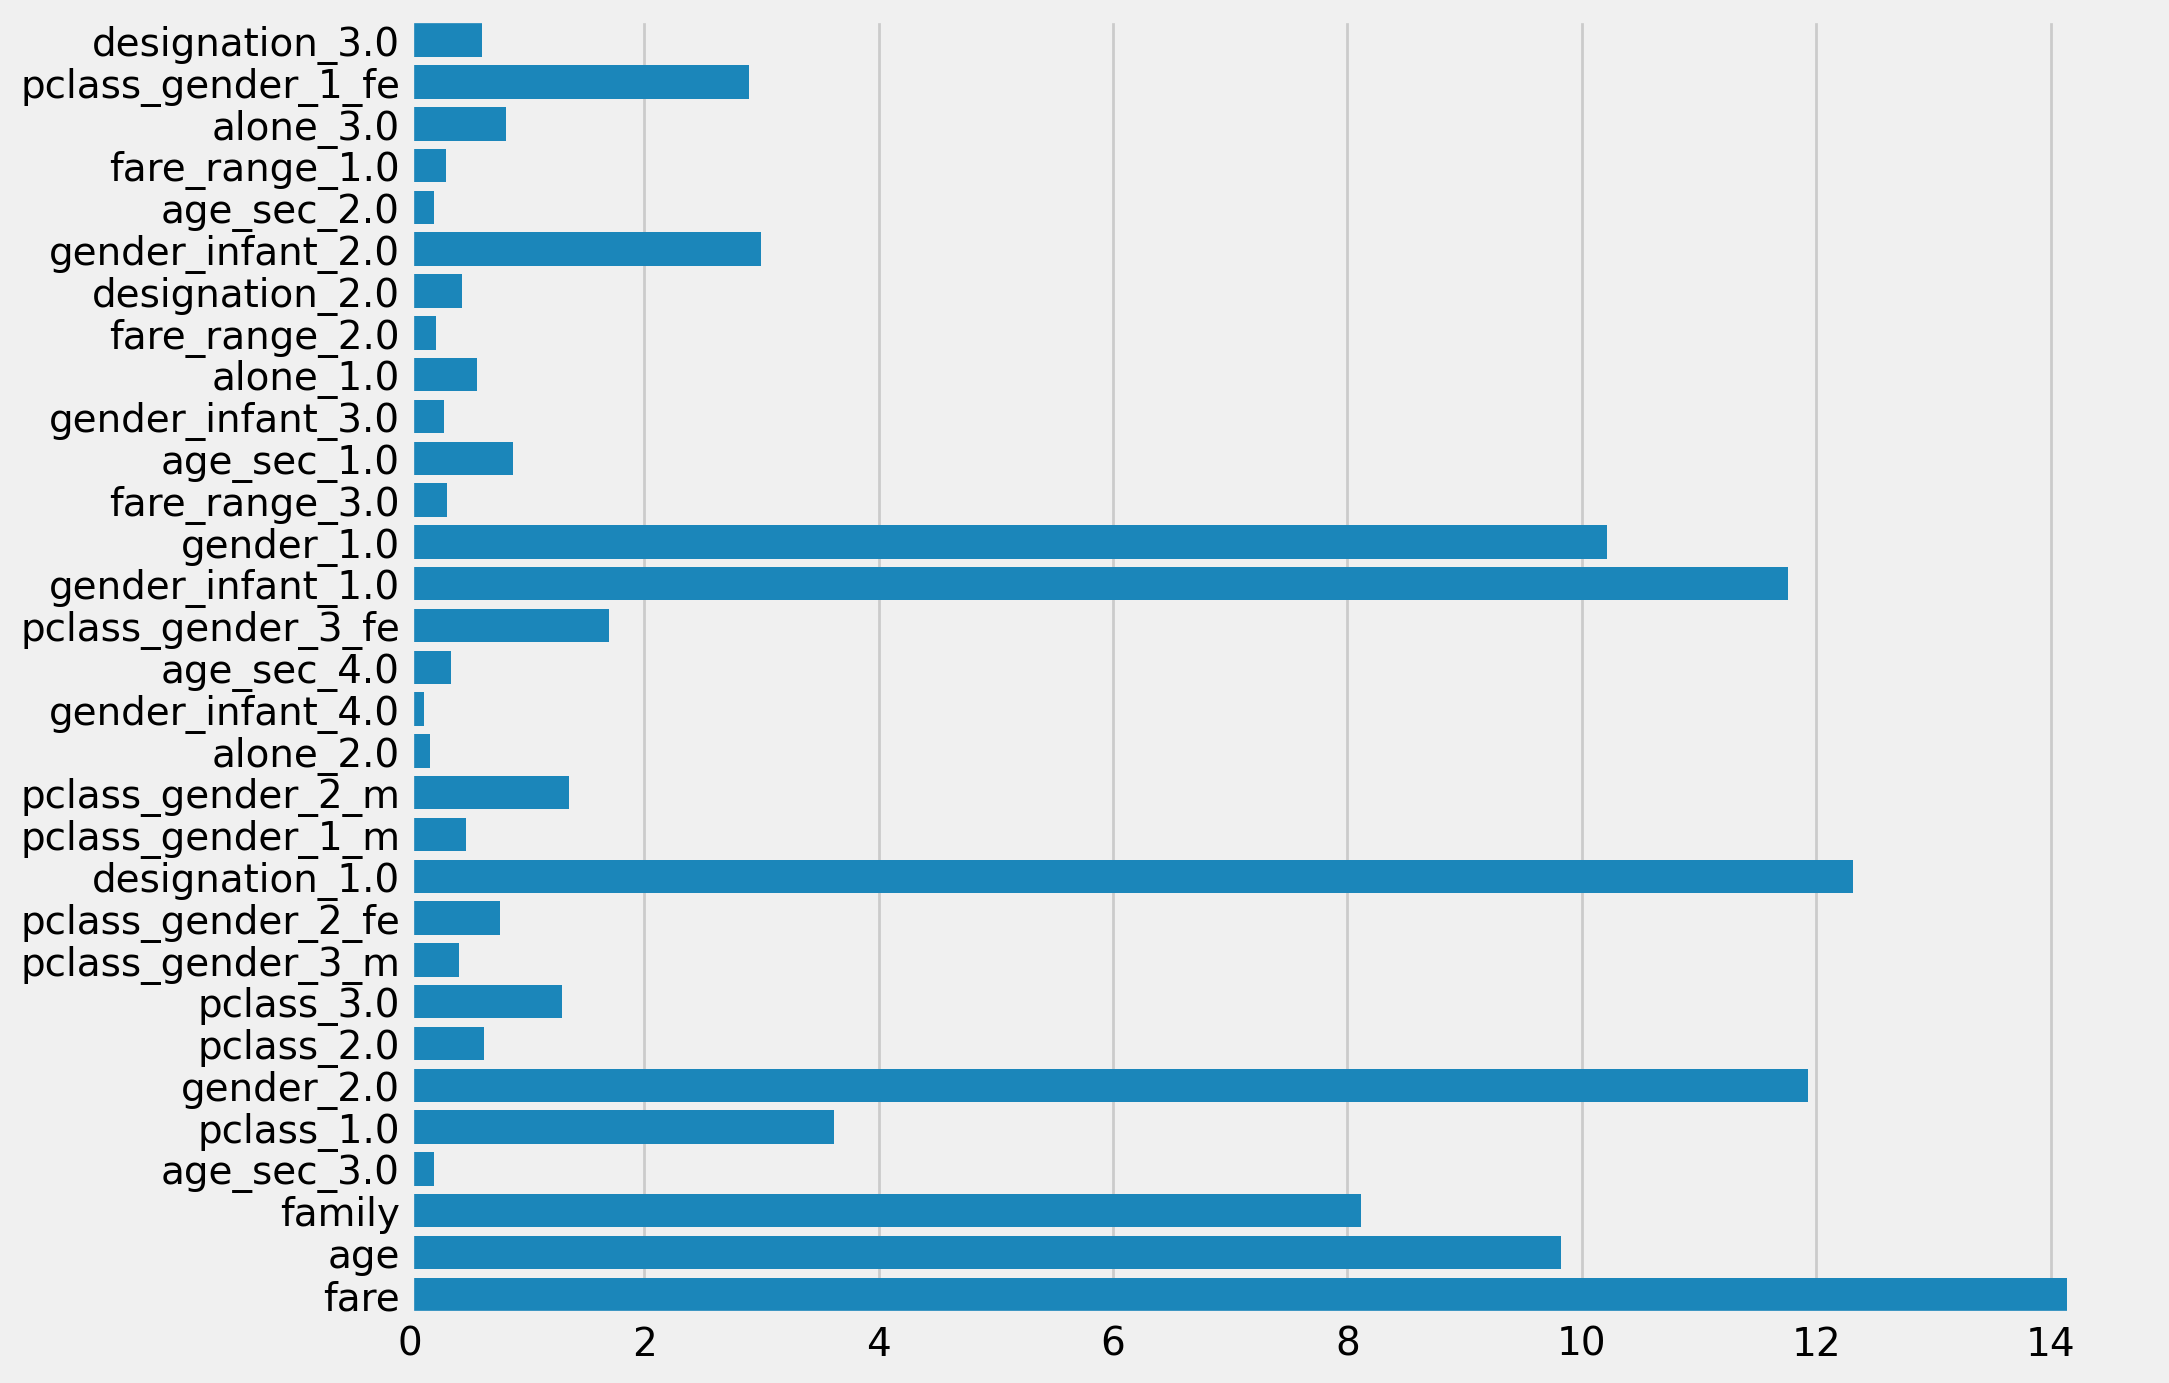

In [ ]:
plt.figure(figsize=(10,8))

sns.barplot(x=cat.feature_importances_,y=scaled_tr.columns.to_numpy())
plt.show()

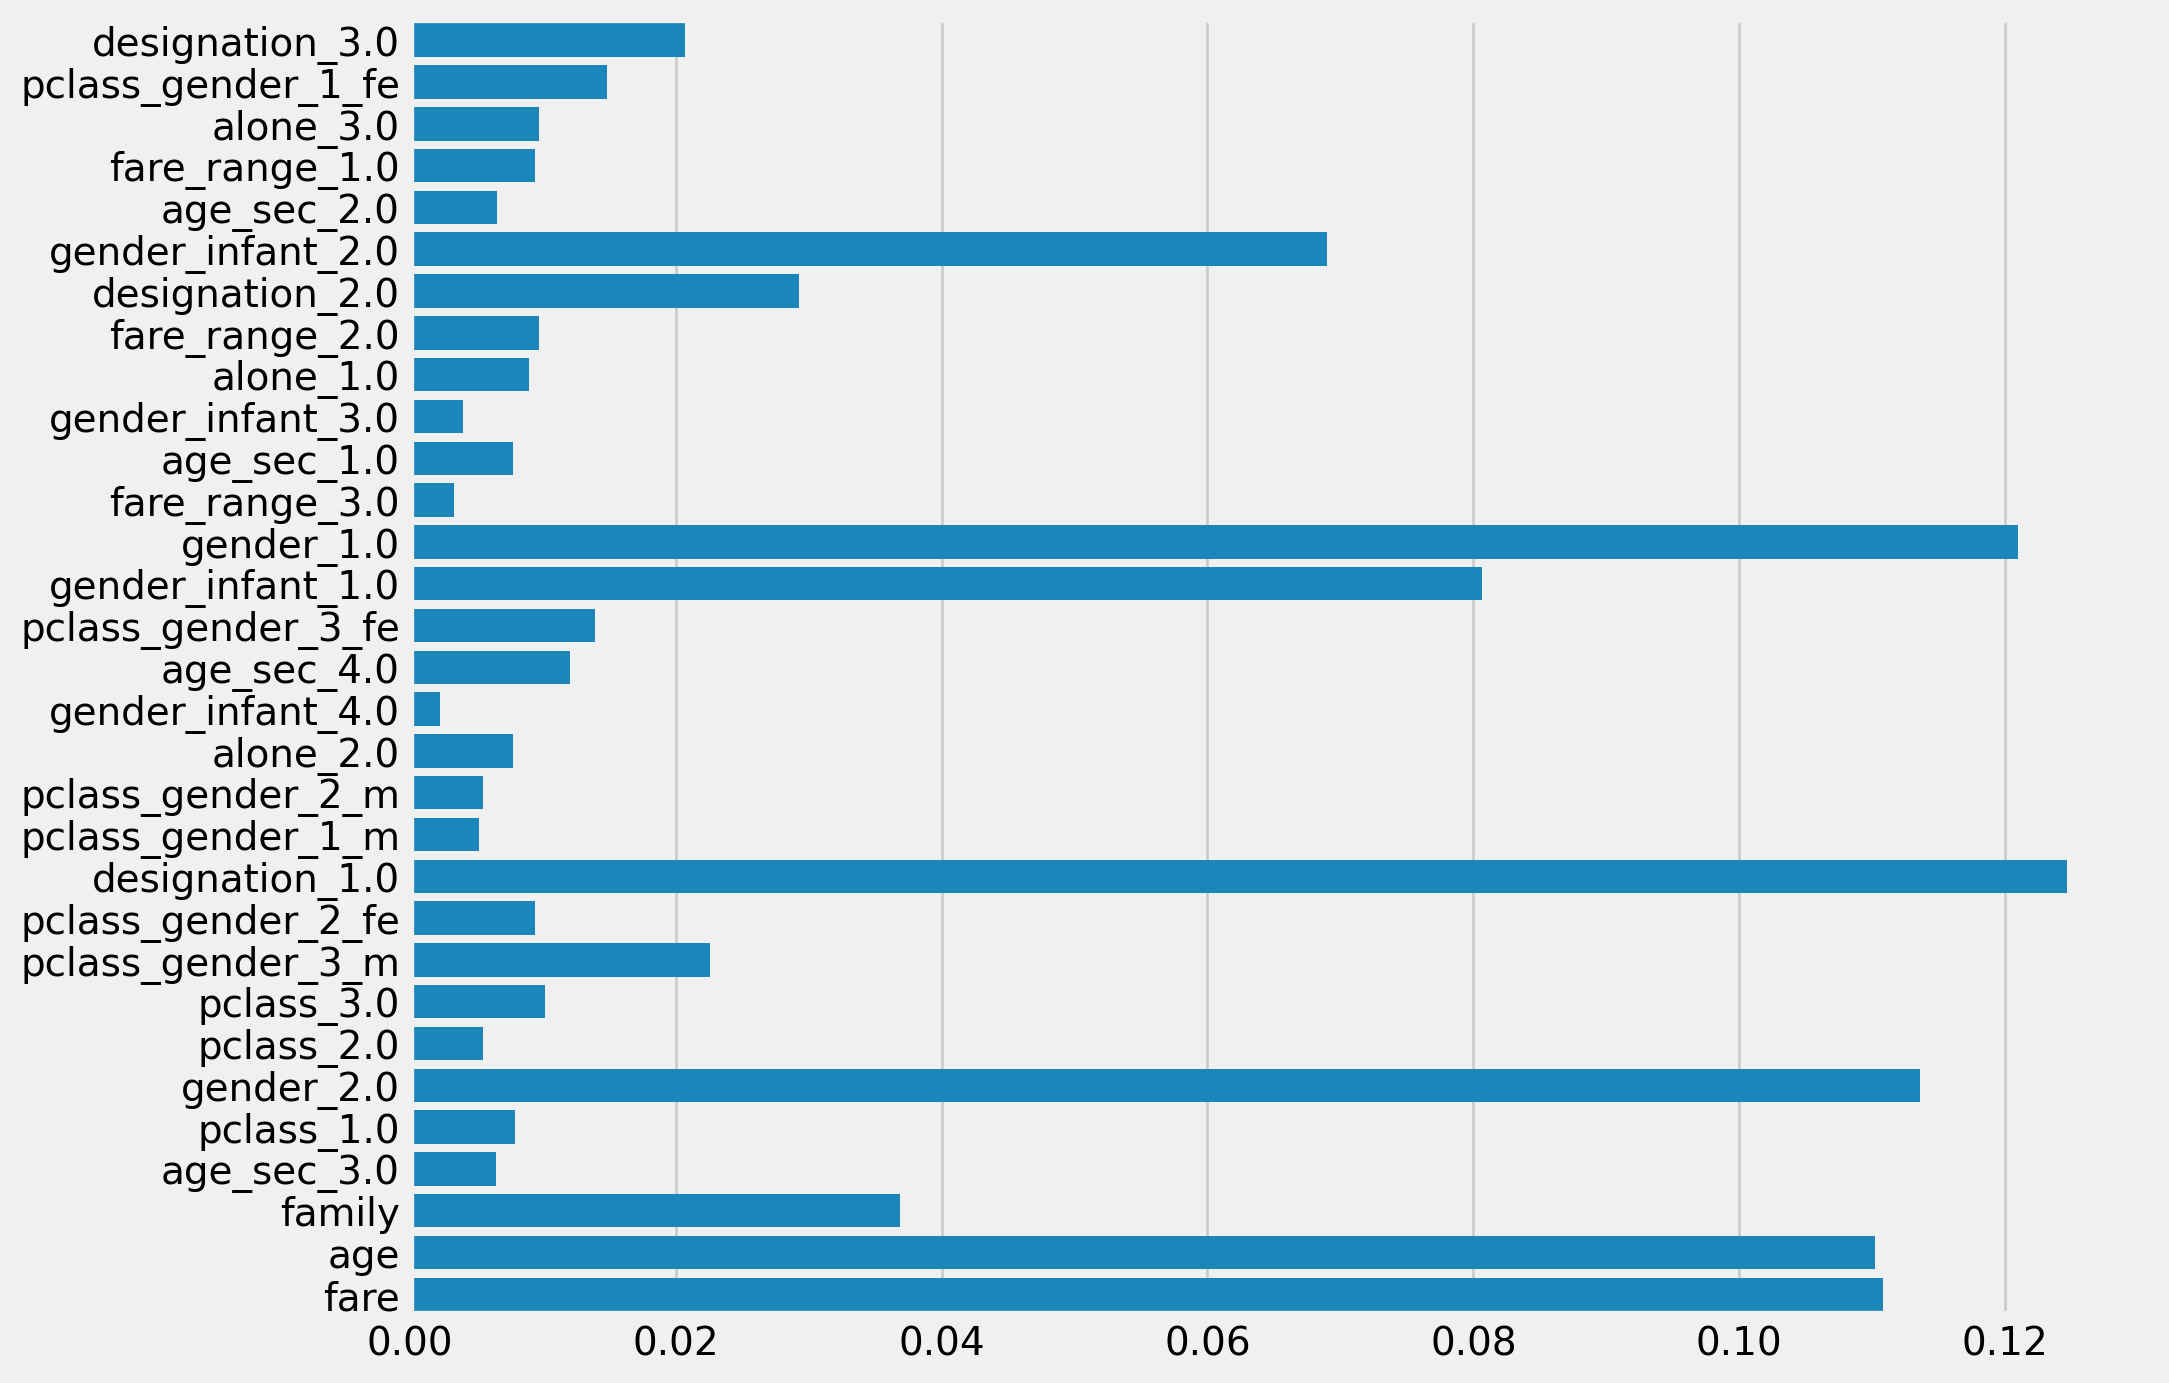

In [ ]:
plt.figure(figsize=(10,8))

sns.barplot(x=rfc.feature_importances_,y=scaled_tr.columns.to_numpy())
plt.show()

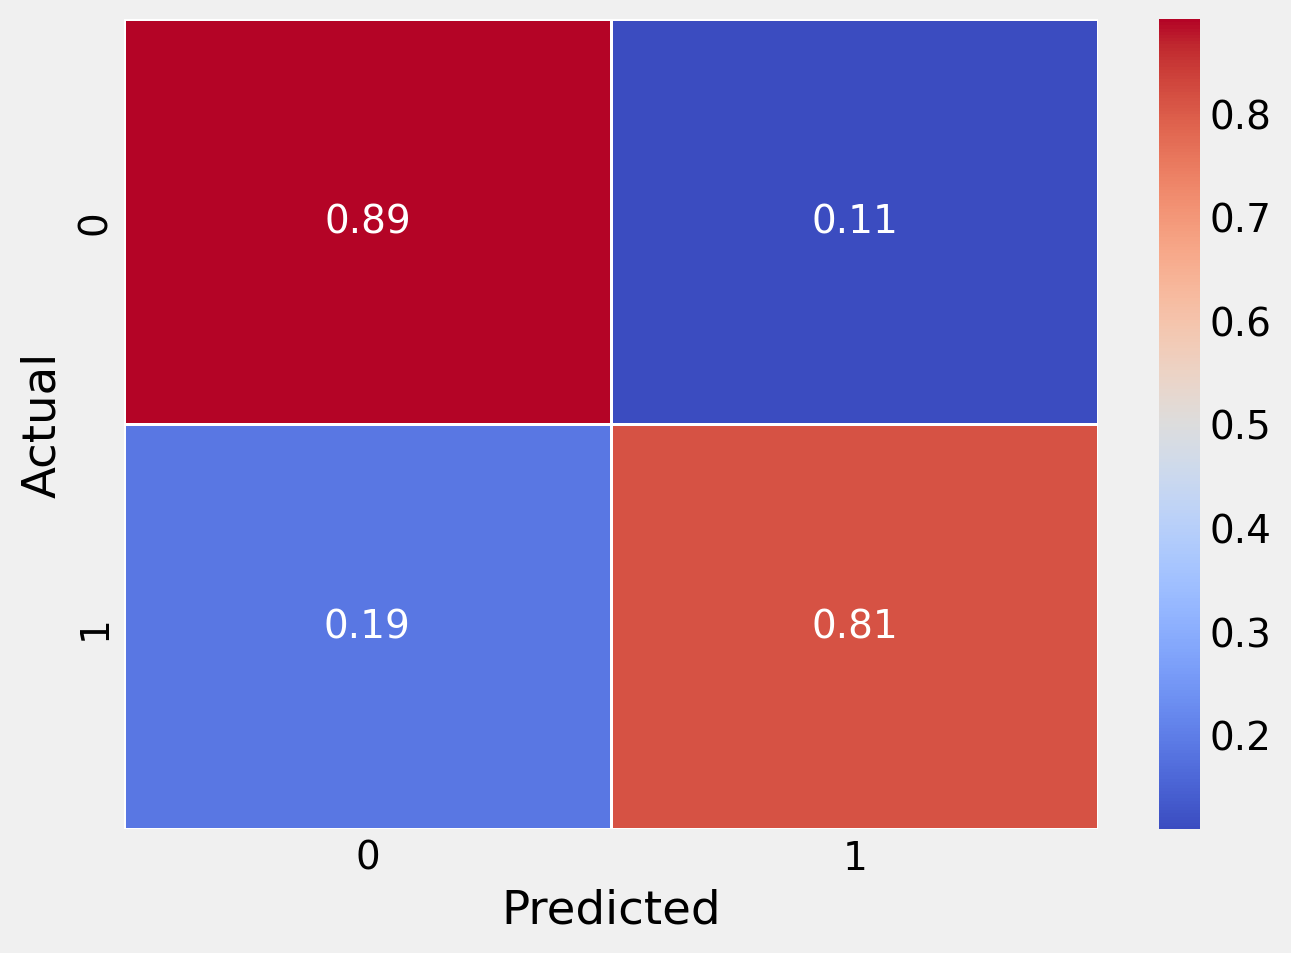

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
norm_conf_mx = confusion_matrix(y_te, np.round(y_pred0), normalize="true")

plt.figure(figsize=(7,5))

sns.heatmap(norm_conf_mx, annot=True, cmap="coolwarm", linewidth=0.5)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


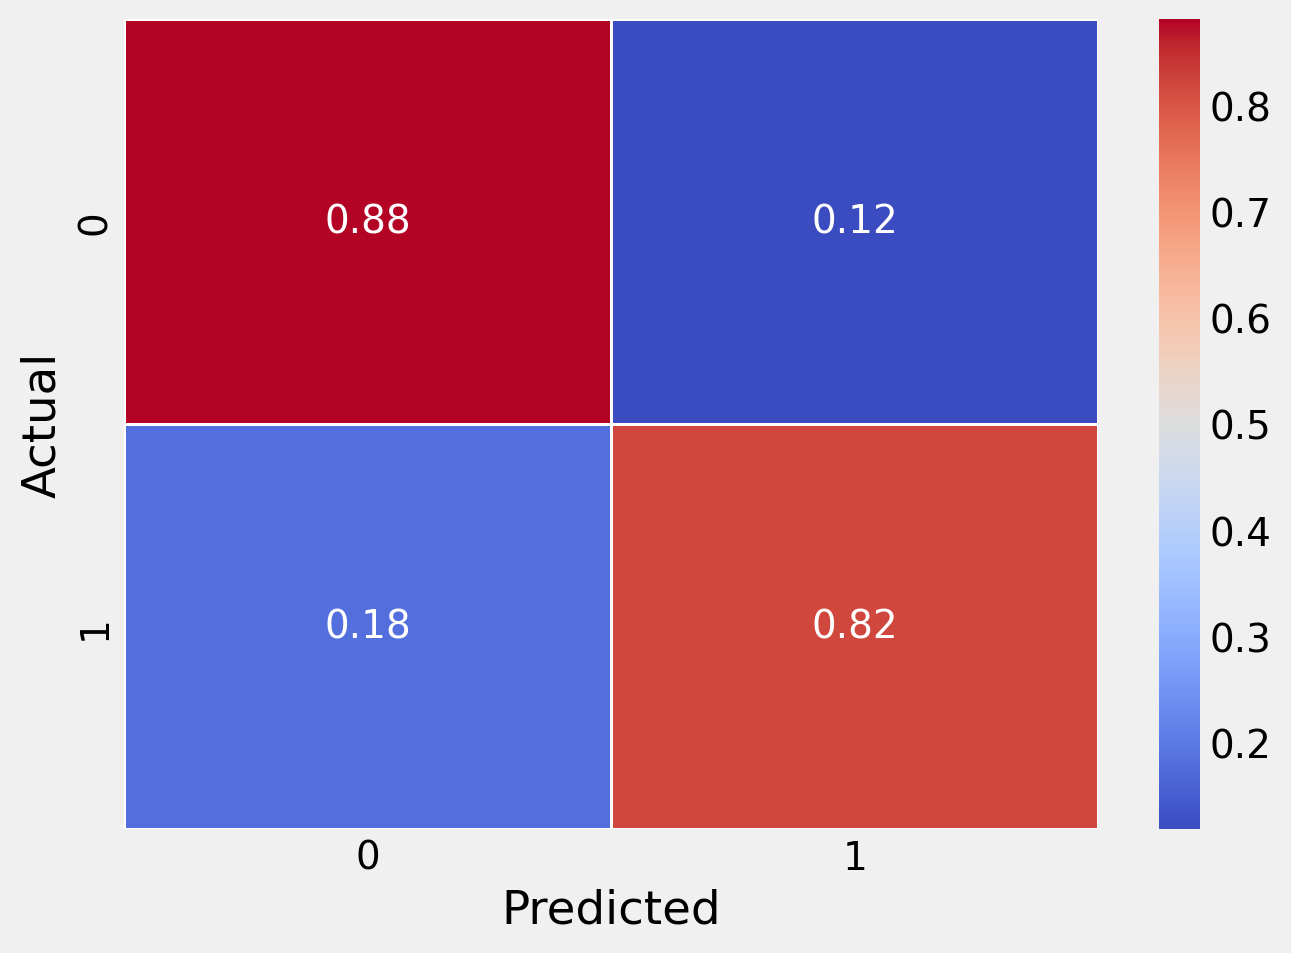

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
norm_conf_mx = confusion_matrix(y_te, np.round(y_pred2), normalize="true")

plt.figure(figsize=(7,5))

sns.heatmap(norm_conf_mx, annot=True, cmap="coolwarm", linewidth=0.5)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


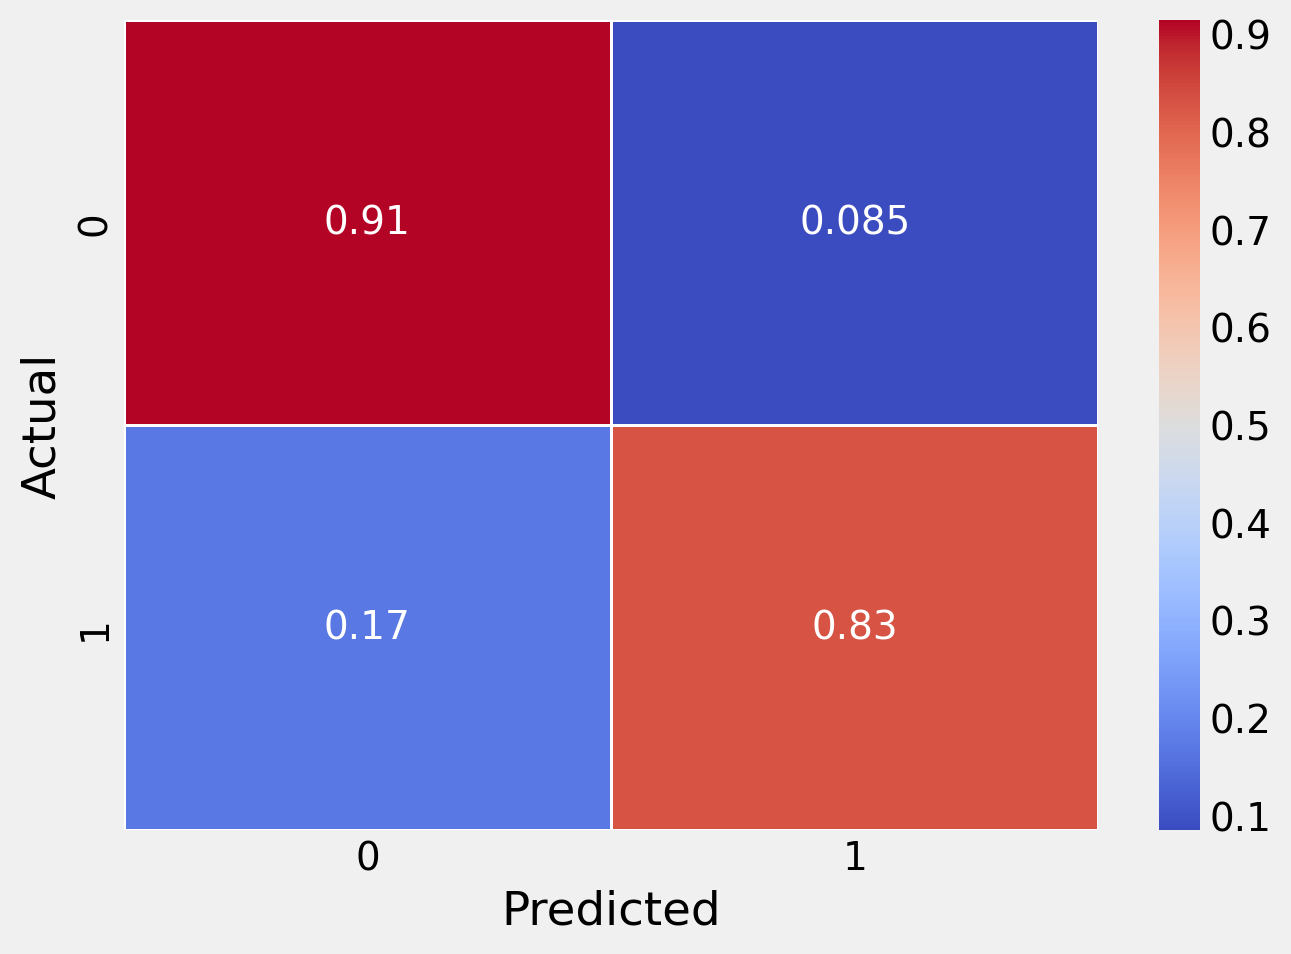

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
norm_conf_mx = confusion_matrix(y_te, np.round(y_pred3), normalize="true")

plt.figure(figsize=(7,5))

sns.heatmap(norm_conf_mx, annot=True, cmap="coolwarm", linewidth=0.5)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


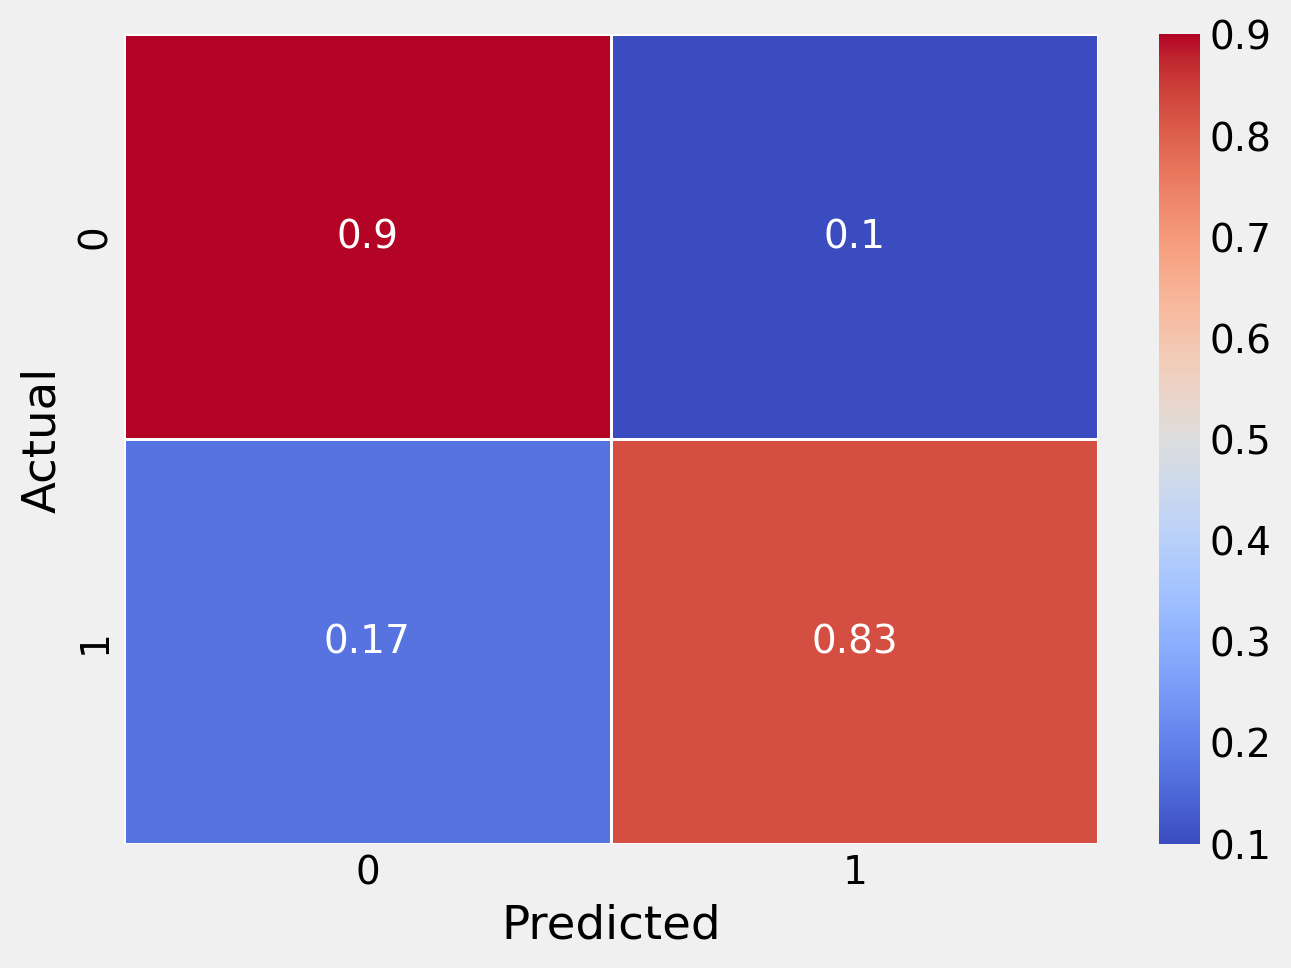

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
norm_conf_mx = confusion_matrix(y_te, np.round(y_pred4), normalize="true")

plt.figure(figsize=(7,5))

sns.heatmap(norm_conf_mx, annot=True, cmap="coolwarm", linewidth=0.5)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


# 결과 해석

In [ ]:
# pandas의 데이터 프레임을 슬라이싱할때 사용한 모듈은 iloc, loc임!!!
# 인덱스(또는 컬럼)의 조건이 True인 것으로 정의를 하면 사용할 있음
tmp_train=pd.concat([X_te.copy().reset_index(drop=True), y_te.copy().reset_index(drop=True)],axis=1)
tmp_train['pred'] = np.round(y_pred0)
tmp_train.shape

(339, 12)

In [ ]:
# FP정의
# 모델은 True & 실제값은 False인 데이터
c1 = tmp_train['survived'] == 0 # 실제값은 False
c2 = tmp_train['pred'] == 1 # 모델은 True
c = c1 & c2

tmp_train.loc[c]

,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked,survived,pred
4,3,"Ilmakangas, Miss. Pieta Sofia",female,25.00,1,0,STON/O2. 3101271,7.9250,NaN,S,0,1.0
9,1,"Brady, Mr. John Bertram",male,41.00,0,0,113054,30.5000,A21,S,0,1.0
18,3,"Peacock, Master. Alfred Edward",male,0.75,1,1,SOTON/O.Q. 3101315,13.7750,NaN,S,0,1.0
21,3,"Hegarty, Miss. Hanora ""Nora""",female,18.00,0,0,365226,6.7500,NaN,Q,0,1.0
33,3,"Heininen, Miss. Wendla Maria",female,23.00,0,0,STON/O2. 3101290,7.9250,NaN,S,0,1.0
34,3,"Zabour, Miss. Thamine",female,NaN,1,0,2665,14.4542,NaN,C,0,1.0
39,3,"Peters, Miss. Katie",female,NaN,0,0,330935,8.1375,NaN,Q,0,1.0
60,2,"Turpin, Mrs. William John Robert (Dorothy Ann ...",female,27.00,1,0,11668,21.0000,NaN,S,0,1.0
68,3,"Palsson, Miss. Torborg Danira",female,8.00,3,1,349909,21.0750,NaN,S,0,1.0
97,3,"Danbom, Master. Gilbert Sigvard Emanuel",male,0.33,0,2,347080,14.4000,NaN,S,0,1.0


In [ ]:
# FN정의
# 모델은 False & 실제값은 True인 데이터
c1 = tmp_train['survived'] == 1 # 실제값은 True
c2 = tmp_train['pred'] == 0 # 모델은 False
c = c1 & c2

tmp_train.loc[c]

,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked,survived,pred
50,1,"Blank, Mr. Henry",male,40.0,0,0,112277,31.0000,A31,C,1,0.0
100,2,"Navratil, Master. Edmond Roger",male,2.0,1,1,230080,26.0000,F2,S,1,0.0
121,3,"Sundman, Mr. Johan Julian",male,44.0,0,0,STON/O 2. 3101269,7.9250,NaN,S,1,0.0
143,1,"Dick, Mr. Albert Adrian",male,31.0,1,0,17474,57.0000,B20,S,1,0.0
145,3,"Lefebre, Mrs. Frank (Frances)",female,NaN,0,4,4133,25.4667,NaN,S,1,0.0
154,1,"Seward, Mr. Frederic Kimber",male,34.0,0,0,113794,26.5500,NaN,S,1,0.0
186,3,"de Mulder, Mr. Theodore",male,30.0,0,0,345774,9.5000,NaN,S,1,0.0
200,3,"Leeni, Mr. Fahim (""Philip Zenni"")",male,22.0,0,0,2620,7.2250,NaN,C,1,0.0
202,2,"Smith, Miss. Marion Elsie",female,40.0,0,0,31418,13.0000,NaN,S,1,0.0
209,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0000,NaN,S,1,0.0


In [ ]:
submission = pd.read_csv(args.default_submission_csv)
submission.head()

,passengerid,survived
0,916,0.5
1,917,0.5
2,918,0.5
3,919,0.5
4,920,0.5


In [ ]:
submission['survived'] = df_results.loc[0, ['ori_te_pred']].values[0]

print(f'{submission.isnull().sum().sum()}')
submission.head(10)

0


,passengerid,survived
0,916,0.764891
1,917,0.964421
2,918,0.766453
3,919,0.061522
4,920,0.976529
5,921,0.884884
6,922,0.077593
7,923,0.044715
8,924,0.412328
9,925,0.099062


In [ ]:
submission.to_csv(args.submission_csv, header=True, index=False)

In [ ]:
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())
# import tensorflow as tf
# print("GPU 사용 가능 여부:", tf.config.list_physical_devices('GPU'))

# Save Results

In [ ]:
args.save_results

'C:/dev/ML_basic/result/model_results.json'

In [ ]:
df_results.columns

Index(['model', 'score_tr', 'score_te', 'auc_tr', 'auc_te', 'len_features',
       'feaute_importances', 'create_dt', 'ori_te_pred'],
      dtype='object')

In [ ]:
df_results.drop(['ori_te_pred'], axis=1, inplace=True) 

In [ ]:
df_results.to_json(args.save_results, orient="records")

In [ ]:
df_results.head()

,model,score_tr,score_te,auc_tr,auc_te,len_features,feaute_importances,create_dt
3,XGB_,0.897747,0.873156,0.949490,0.928336,31,"[gender_1.0, gender_infant_1.0, pclass_gender_...",0217
0,rfc,0.927210,0.861357,0.974176,0.928132,31,"[designation_1.0, gender_1.0, gender_2.0, fare...",0217
2,cat,0.896014,0.882006,0.942616,0.927744,31,"[fare, designation_1.0, gender_2.0, gender_inf...",0217
1,light,0.897747,0.858407,0.948717,0.923782,31,"[fare, age, gender_1.0, family, alone_1.0, pcl...",0217


In [ ]:
import json

load_results = None
with open(args.save_results, 'r') as file:
    load_results = json.load(file)

load_results

[{'model': 'XGB_',
  'score_tr': 0.8977469671,
  'score_te': 0.8731563422,
  'auc_tr': 0.949490174,
  'auc_te': 0.9283360486,
  'len_features': 31,
  'feaute_importances': ['gender_1.0',
   'gender_infant_1.0',
   'pclass_gender_1_m',
   'pclass_3.0',
   'family',
   'pclass_gender_3_fe',
   'designation_2.0',
   'pclass_gender_1_fe',
   'alone_3.0',
   'alone_2.0'],
  'create_dt': '0217'},
 {'model': 'rfc',
  'score_tr': 0.9272097054,
  'score_te': 0.8613569322,
  'auc_tr': 0.9741764841,
  'auc_te': 0.9281324052,
  'len_features': 31,
  'feaute_importances': ['designation_1.0',
   'gender_1.0',
   'gender_2.0',
   'fare',
   'age',
   'gender_infant_1.0',
   'gender_infant_2.0',
   'family',
   'designation_2.0',
   'pclass_gender_3_m'],
  'create_dt': '0217'},
 {'model': 'cat',
  'score_tr': 0.8960138648,
  'score_te': 0.8820058997,
  'auc_tr': 0.9426158289,
  'auc_te': 0.9277436315,
  'len_features': 31,
  'feaute_importances': ['fare',
   'designation_1.0',
   'gender_2.0',
   'gen

In [ ]:
##